In [5]:
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import behaviour_functions as bhv
import statsmodels.api as sm
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

# import statsmodels.formula.api as smf
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
path = '/Volumes/lab-kohlj/home/shared/people/Irene/Chemoinhibitions/scored/BNST/'
IDs = ['BRAC9284.3k', 'BRAC9284.3g', 'BRAC9595.2b', 'BRAC9562.6f', 'BRAC9842.3h', 
       'BRAC9843.3i', 'BRAC9842.3g', 'BRAC9562.6e','BRAC9925.2d', 'BRAC10307.5f', 
       'BRAC10608.2f', 'BRAC10102.4c', 'BRAC10102.4d', 'BRAC10102.4e'] # experimental group
IDs_ctrl = ['BRAC9767.2f', 'BRAC9788.3e', 'BRAC9767.2c', 'BRAC9843.3g', 'BRAC10534.2e', 
            'BRAC10607.2d', 'BRAC10636.2d'] # control group
times = ['baselinepre', 'baselinepost', 'day1', 'day2', 'day3', 'day4']

In [3]:
# initialize dataframe for experimental group
behaviours = pd.DataFrame(columns = ["ID", "group", "time", "behaviour", "latency", "duration"])

# combine all IDs into a dictionary with their respective groups
group_mapping = {ID: "experimental" for ID in IDs}
group_mapping.update({ID: "control" for ID in IDs_ctrl})

# extract behaviours for each ID and each experimental time point
for ID, group in group_mapping.items():
    for time in times:
        try:
            # get the paths for each file in dataset, read csv files into a dataframe
            file = glob(path + f'{ID}_virgin_{time}_*.csv')
            # print(file)
            df = pd.read_csv(file[0])
        except IndexError:
            df = pd.DataFrame(columns = df.columns)
            print(f'{ID}_virgin_{time}_scored*.csv')
            continue

        
        # organise behavioural data and calculate latency and duration of behaviours
        behaviours = bhv.organise_behav_new(df, ID, time, behaviours, 'time')

        # add group information for the current ID
        behaviours.loc[behaviours["ID"] == ID, "group"] = group


# turn values in time to categorical and order them
behaviours.time = pd.Categorical(behaviours.time, categories = times, ordered = True)

# save behaviour dataframe as csv",
behaviours.to_csv('/Users/irenesalgarella/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/generated_dataset/bnst_telc_behaviours_df.csv')

BRAC10102.4c_virgin_baselinepost_scored*.csv


In [7]:
behaviours[behaviours.behaviour == 'overall retrieval']

,ID,group,time,behaviour,latency,duration
5,BRAC9284.3k,experimental,baselinepre,overall retrieval,900,0
13,BRAC9284.3k,experimental,baselinepost,overall retrieval,900,0
21,BRAC9284.3k,experimental,day1,overall retrieval,385.75,17.05
29,BRAC9284.3k,experimental,day2,overall retrieval,176.35,18.2
37,BRAC9284.3k,experimental,day3,overall retrieval,382.1,15.3
...,...,...,...,...,...,...
965,BRAC10636.2d,control,baselinepost,overall retrieval,333.75,8.8
973,BRAC10636.2d,control,day1,overall retrieval,335.2,32.0
981,BRAC10636.2d,control,day2,overall retrieval,191.55,6.55
989,BRAC10636.2d,control,day3,overall retrieval,37.2,11.9


In [4]:
percentages = pd.DataFrame(columns=["time", "behaviour", "group", "percentage"])

for time in times:
    for behaviour in behaviours.behaviour.unique():
        per_df = behaviours[(behaviours.behaviour == behaviour) & (behaviours.time == time)]

        for group in per_df.group.unique():
            group_df = per_df[per_df.group == group]  # Filter by group
            num = group_df[group_df.duration == 0].shape[0]  # Animals that did not perform the behaviour
            if group_df.shape[0] > 0:
                percent = (group_df.shape[0] - num) / group_df.shape[0]  # Percentage of animals performing
            else:
                percent = None  # Handle cases where there are no animals in the group

            percentage = pd.DataFrame({
                "time": [time],
                "behaviour": [behaviour],
                "group": [group],
                "percentage": [percent]
            })
            
            percentages = pd.concat([percentages, percentage], ignore_index=True)


In [6]:
# TWO-WAY FISHER'S EXACT TEST WITH FDR CORRECTION - RETRIEVAL TO NEST ONLY

# First, we need to create contingency tables of counts, not percentages
# We'll need to go back to the original behavior data

# Define the behavior of interest - modify this if the exact name is different
target_behavior = 'retrieval to nest'  

# Check if the target behavior exists in the dataset
if target_behavior not in behaviours.behaviour.unique():
    # Try to find a similar behavior if exact match doesn't exist
    retrieval_behaviors = [b for b in behaviours.behaviour.unique() if 'retrieval' in b.lower()]
    if retrieval_behaviors:
        target_behavior = retrieval_behaviors[0]  # Use the first retrieval behavior found
        print(f"Using '{target_behavior}' as the target behavior")
    else:
        print("No retrieval behavior found in the dataset")

fishers_results = pd.DataFrame(columns=[
    'time', 'exp_performing', 'exp_total', 'exp_percent',
    'ctrl_performing', 'ctrl_total', 'ctrl_percent', 'odds_ratio', 'p_value'
])

# Loop through each time point for the target behavior
for time in times:
    # Get data for this behavior and time
    behav_time_df = behaviours[(behaviours.behaviour == target_behavior) & (behaviours.time == time)]
    
    # Skip if either group is missing
    if len(behav_time_df['group'].unique()) < 2:
        continue
        
    # Calculate counts for experimental group
    exp_df = behav_time_df[behav_time_df.group == 'experimental']
    exp_total = len(exp_df)
    exp_performing = len(exp_df[exp_df.duration > 0])
    exp_not_performing = exp_total - exp_performing
    exp_percent = exp_performing / exp_total if exp_total > 0 else 0
    
    # Calculate counts for control group
    ctrl_df = behav_time_df[behav_time_df.group == 'control']  
    ctrl_total = len(ctrl_df)
    ctrl_performing = len(ctrl_df[ctrl_df.duration > 0])
    ctrl_not_performing = ctrl_total - ctrl_performing
    ctrl_percent = ctrl_performing / ctrl_total if ctrl_total > 0 else 0
    
    # Create contingency table
    # [performing, not performing]
    # [experimental, control]
    contingency_table = [
        [exp_performing, exp_not_performing],
        [ctrl_performing, ctrl_not_performing]
    ]
    
    # Perform Fisher's exact test
    try:
        odds_ratio, p_value = fisher_exact(contingency_table)
        
        # Append results
        fishers_results = pd.concat([fishers_results, pd.DataFrame({
            'time': [time],
            'exp_performing': [exp_performing],
            'exp_total': [exp_total],
            'exp_percent': [exp_percent],
            'ctrl_performing': [ctrl_performing], 
            'ctrl_total': [ctrl_total],
            'ctrl_percent': [ctrl_percent],
            'odds_ratio': [odds_ratio],
            'p_value': [p_value]
        })], ignore_index=True)
        
    except Exception as e:
        print(f"Error analyzing {target_behavior} at {time}: {e}")

# Apply multiple testing correction (FDR) if there are multiple time points
if len(fishers_results) > 1:
    _, corrected_pvals, _, _ = multipletests(
        fishers_results['p_value'], 
        method='fdr_bh'  # Benjamini-Hochberg FDR
    )
    fishers_results['adjusted_p_value'] = corrected_pvals
else:
    # If only one test was performed, no correction needed
    fishers_results['adjusted_p_value'] = fishers_results['p_value']

# Add significance indicators
fishers_results['significance'] = 'ns'
fishers_results.loc[fishers_results['adjusted_p_value'] < 0.05, 'significance'] = '*'
fishers_results.loc[fishers_results['adjusted_p_value'] < 0.01, 'significance'] = '**'
fishers_results.loc[fishers_results['adjusted_p_value'] < 0.001, 'significance'] = '***'
fishers_results.loc[fishers_results['adjusted_p_value'] < 0.0001, 'significance'] = '****'

# Print summary table
print(f"\nFisher's Exact Test Results for {target_behavior}:")
summary_table = fishers_results[['time', 'exp_percent', 'ctrl_percent', 'p_value', 'adjusted_p_value', 'significance']]
summary_table = summary_table.rename(columns={
    'time': 'Time Point',
    'exp_percent': 'Exp Group (%)',
    'ctrl_percent': 'Ctrl Group (%)',
    'p_value': 'Raw p-value',
    'adjusted_p_value': 'FDR Corrected p-value',
    'significance': 'Significance'
})

# Format percentage columns to show as percentages
summary_table['Exp Group (%)'] = summary_table['Exp Group (%)'].apply(lambda x: f"{x:.1%}")
summary_table['Ctrl Group (%)'] = summary_table['Ctrl Group (%)'].apply(lambda x: f"{x:.1%}")

# Format p-values to scientific notation for very small values
summary_table['Raw p-value'] = summary_table['Raw p-value'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else f"{x:.2e}")
summary_table['FDR Corrected p-value'] = summary_table['FDR Corrected p-value'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else f"{x:.2e}")

print(summary_table.to_string(index=False))

# Save results to CSV
fishers_results.to_csv('retrieval_to_nest_fishers_results.csv', index=False)


Fisher's Exact Test Results for retrieval to nest:
  Time Point Exp Group (%) Ctrl Group (%) Raw p-value FDR Corrected p-value Significance
 baselinepre          7.1%           0.0%      1.0000                1.0000           ns
baselinepost         30.8%          14.3%      0.6126                1.0000           ns
        day1         42.9%          42.9%      1.0000                1.0000           ns
        day2         64.3%          71.4%      1.0000                1.0000           ns
        day3         64.3%         100.0%      0.1235                0.3705           ns
        day4         57.1%         100.0%      0.0609                0.3653           ns


/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


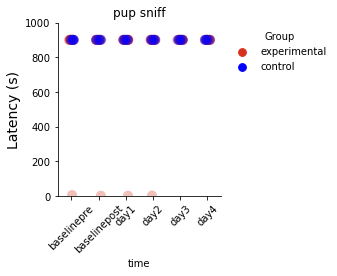

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


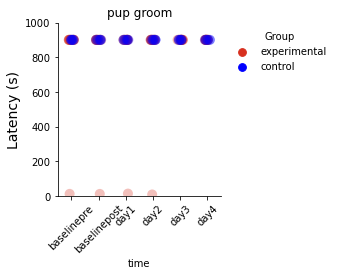

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


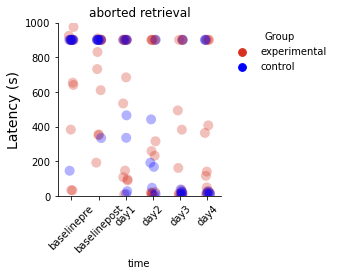

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


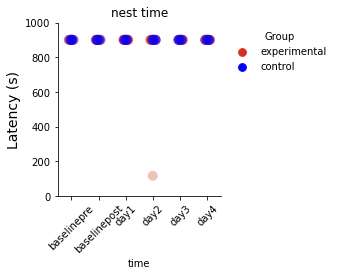

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


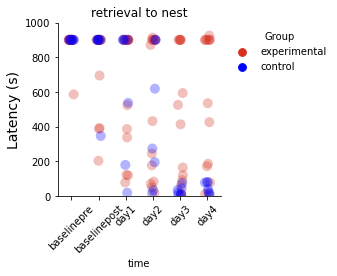

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


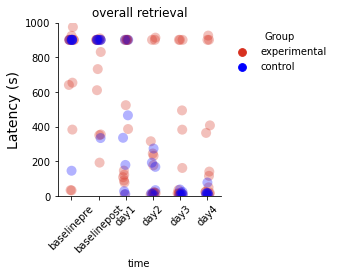

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


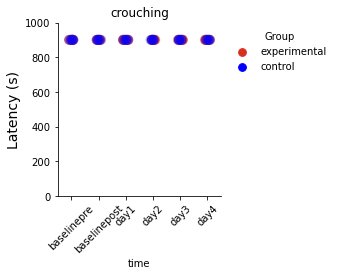

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/2053743773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


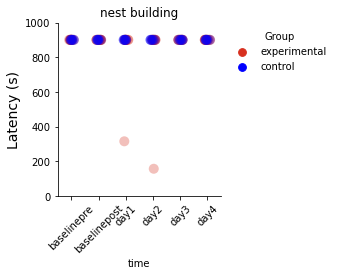

In [9]:
for behaviour in behaviours.behaviour.unique():
    behav_df = behaviours[behaviours.behaviour == behaviour]
    
    behav_df.latency = pd.to_numeric(behav_df.latency)
    # mean = behav_df.groupby(by = 'time').mean().reset_index()
    # st_error = behav_df.groupby(by = 'time').std()/np.sqrt(len(behav_df.ID.unique()))
    # st_error = st_error.reset_index()
    
    # model = smf.ols('latency ~ C(time)', data = behav_df).fit()
    # print(sm.stats.anova_lm(model, typ = 2))
    
    # m_comp = pairwise_tukeyhsd(endog=behav_df.latency, groups = behav_df.time, alpha = 0.05)
    # print(m_comp._results_table)

    
#     fig, ax = plt.subplots(figsize = [10, 5])
#     fig.tight_layout()
    
#     plt.plot(mean.time, mean.latency, color = 'purple', alpha = 0.7)
#     plt.fill_between(mean.time,  mean.latency + st_error.latency, mean.latency - st_error.latency, 
#                      color = 'purple', alpha = 0.05)
    
#     ax.set_xlim(['baseline', 'day50'])
#     ax.set_ylim([0, 900])
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
#     plt.xticks(fontsize = 12)
#     plt.yticks(fontsize = 12)
    
#     plt.ylabel('Latency (s)', fontsize = 14)
    
#     plt.title(behaviour)
    
#     plt.savefig(f'plots/{behaviour}_latency.jpg', dpi = 300, bbox_inches = 'tight')
#     plt.show()

    
#     fig, ax = plt.subplots(figsize = [10, 5])
#     fig.tight_layout()
    
#     sns.pointplot(mean.time, mean.latency, color = 'purple', alpha = 0.7)
#     # plt.fill_between(mean.time,  mean.latency + st_error.latency, mean.latency - st_error.latency, 
#                      # color = 'purple', alpha = 0.05)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
#     plt.xticks(fontsize = 12)
#     plt.yticks(fontsize = 12)
    
#     plt.ylabel('Latency (s)', fontsize = 14)
#     plt.title(behaviour)
#     plt.show()
    
    fig, ax = plt.subplots(figsize = [3,3])
    fig.tight_layout()
    
    # define custom palette for the two groups
    custom_palette = {"experimental": "#d7301f", "control": "blue"}

    # sns.boxplot(x='time', y='latency', data = behav_df, color = 'white', width = 0.5)
    sns.stripplot(x = "time", y = "latency", data = behav_df, hue = 'group', palette = custom_palette, alpha = 0.3, size = 10)
    # sns.barplot(x = "time", y = "latency", data = mean, palette = ["purple"], errorbar = "se", alpha = 0.3)
    # sns.lineplot(x = "time", y = "latency", data = behav_df, style = "ID", color = 'grey', alpha = 0.4, size = 7, marker = 'o', markersize=10, markerfacecolor='purple',legend = False)
    ax.set_ylim([0, 1000])
    plt.ylabel('Latency (s)', fontsize = 14)
    plt.title(behaviour)
    plt.xticks(rotation=45)
    sns.despine()
    
   # adjust legend position
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Group", loc='upper right', bbox_to_anchor=(1.7, 1), frameon=False)

    # plt.savefig(f'plots_chem_bnst/{behaviour}_latency.jpg', dpi = 300, bbox_inches = 'tight')
    plt.show()

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


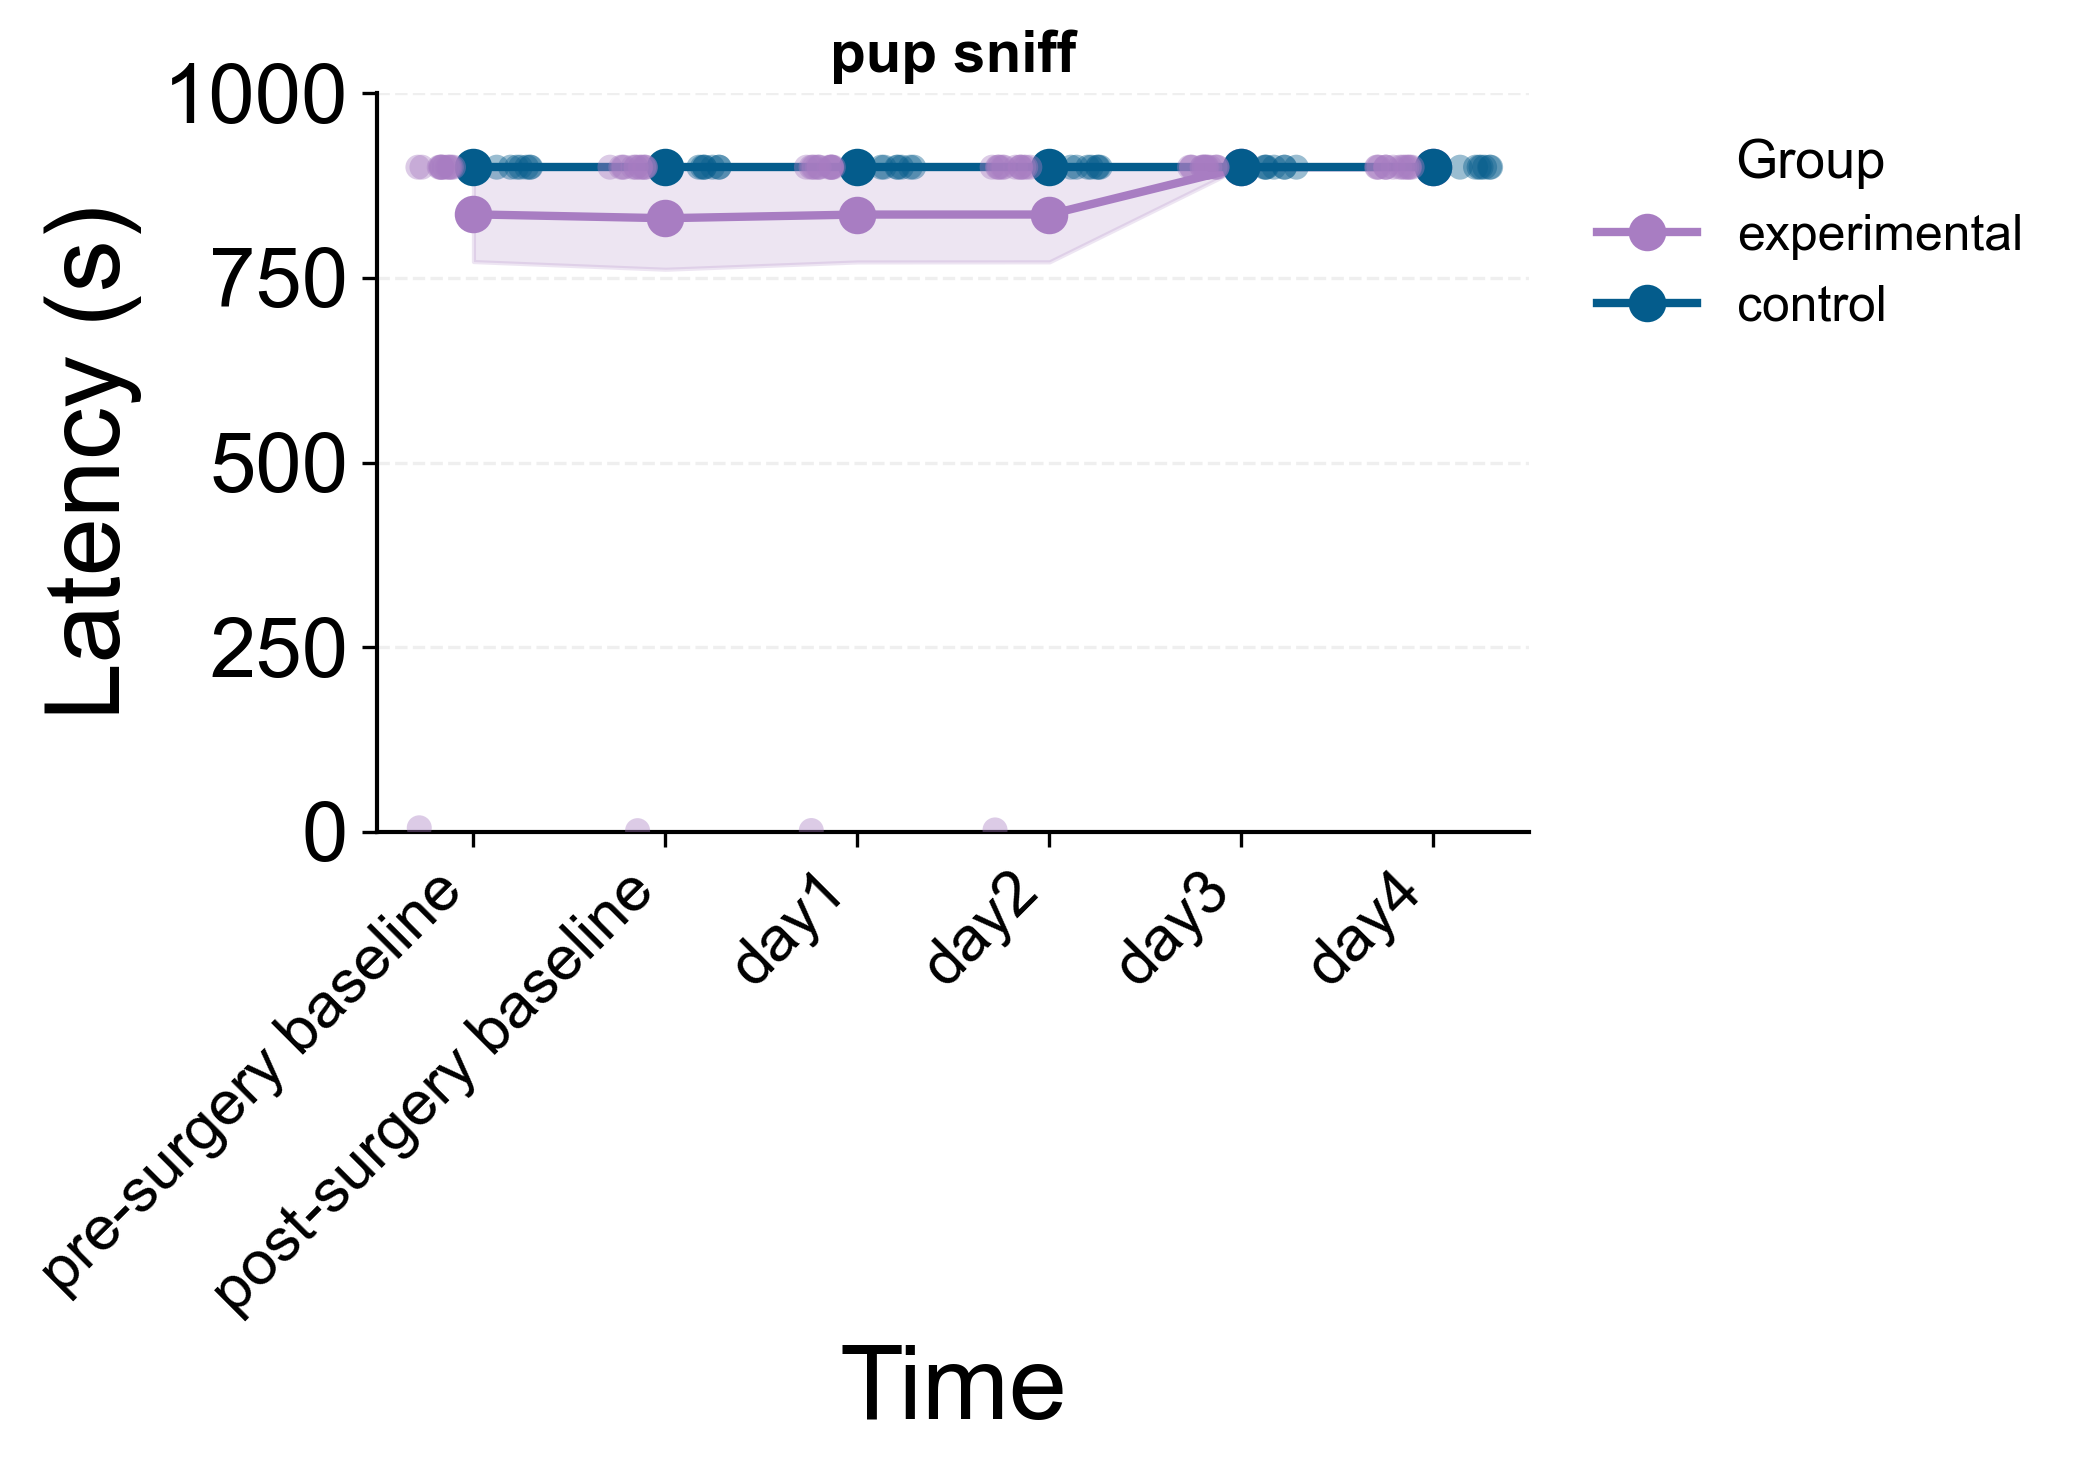

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


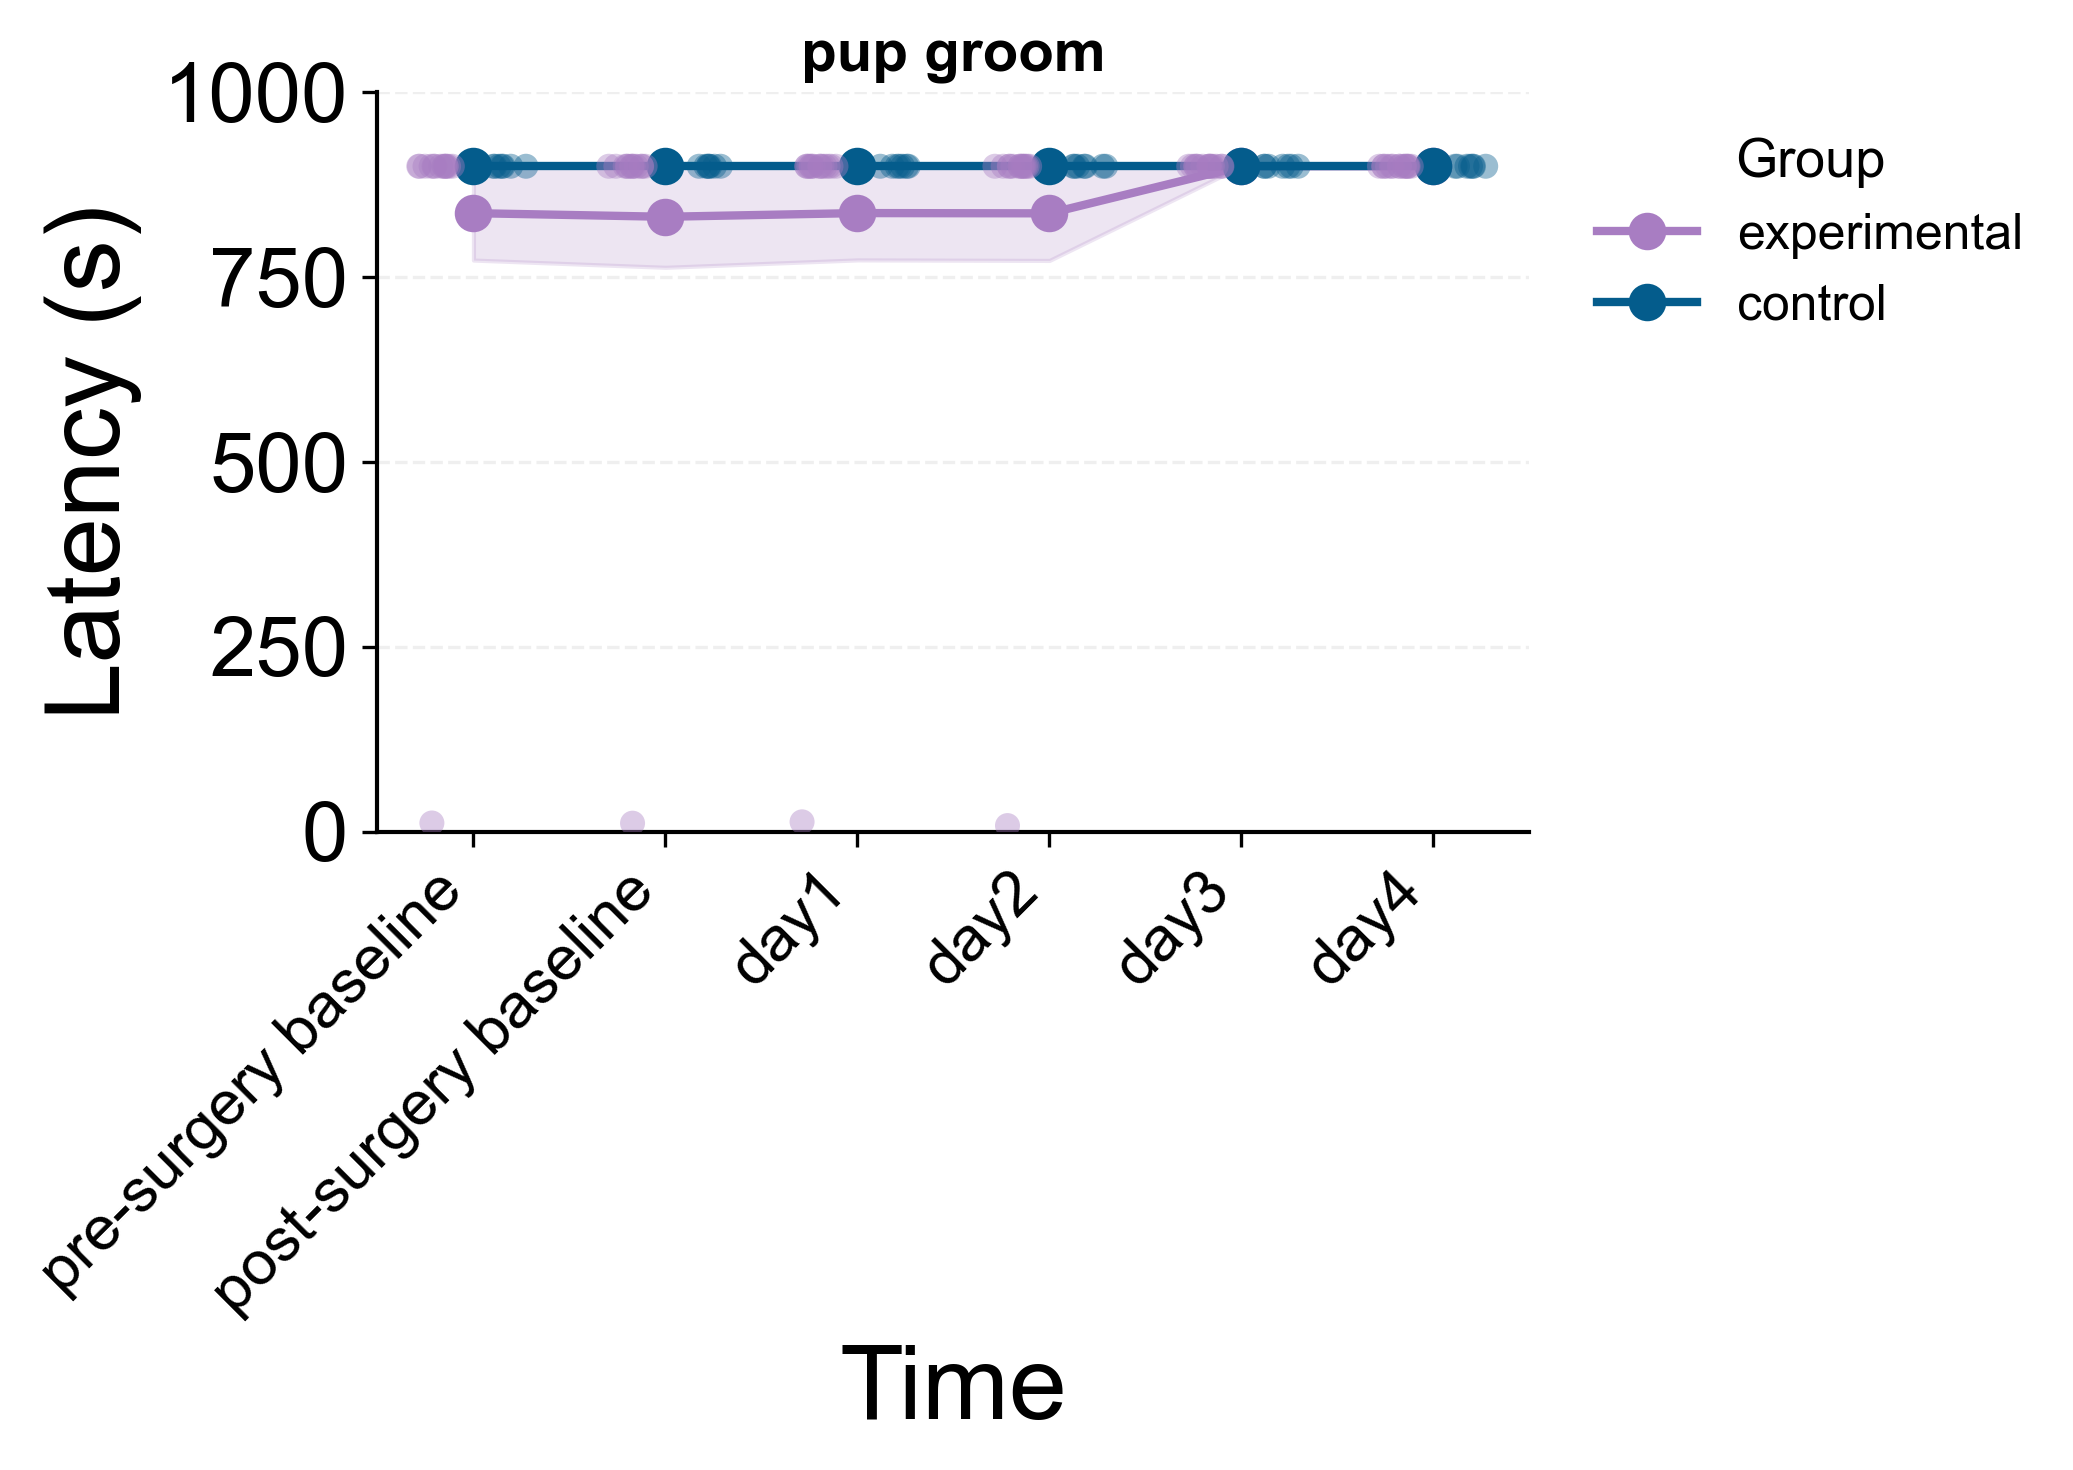

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


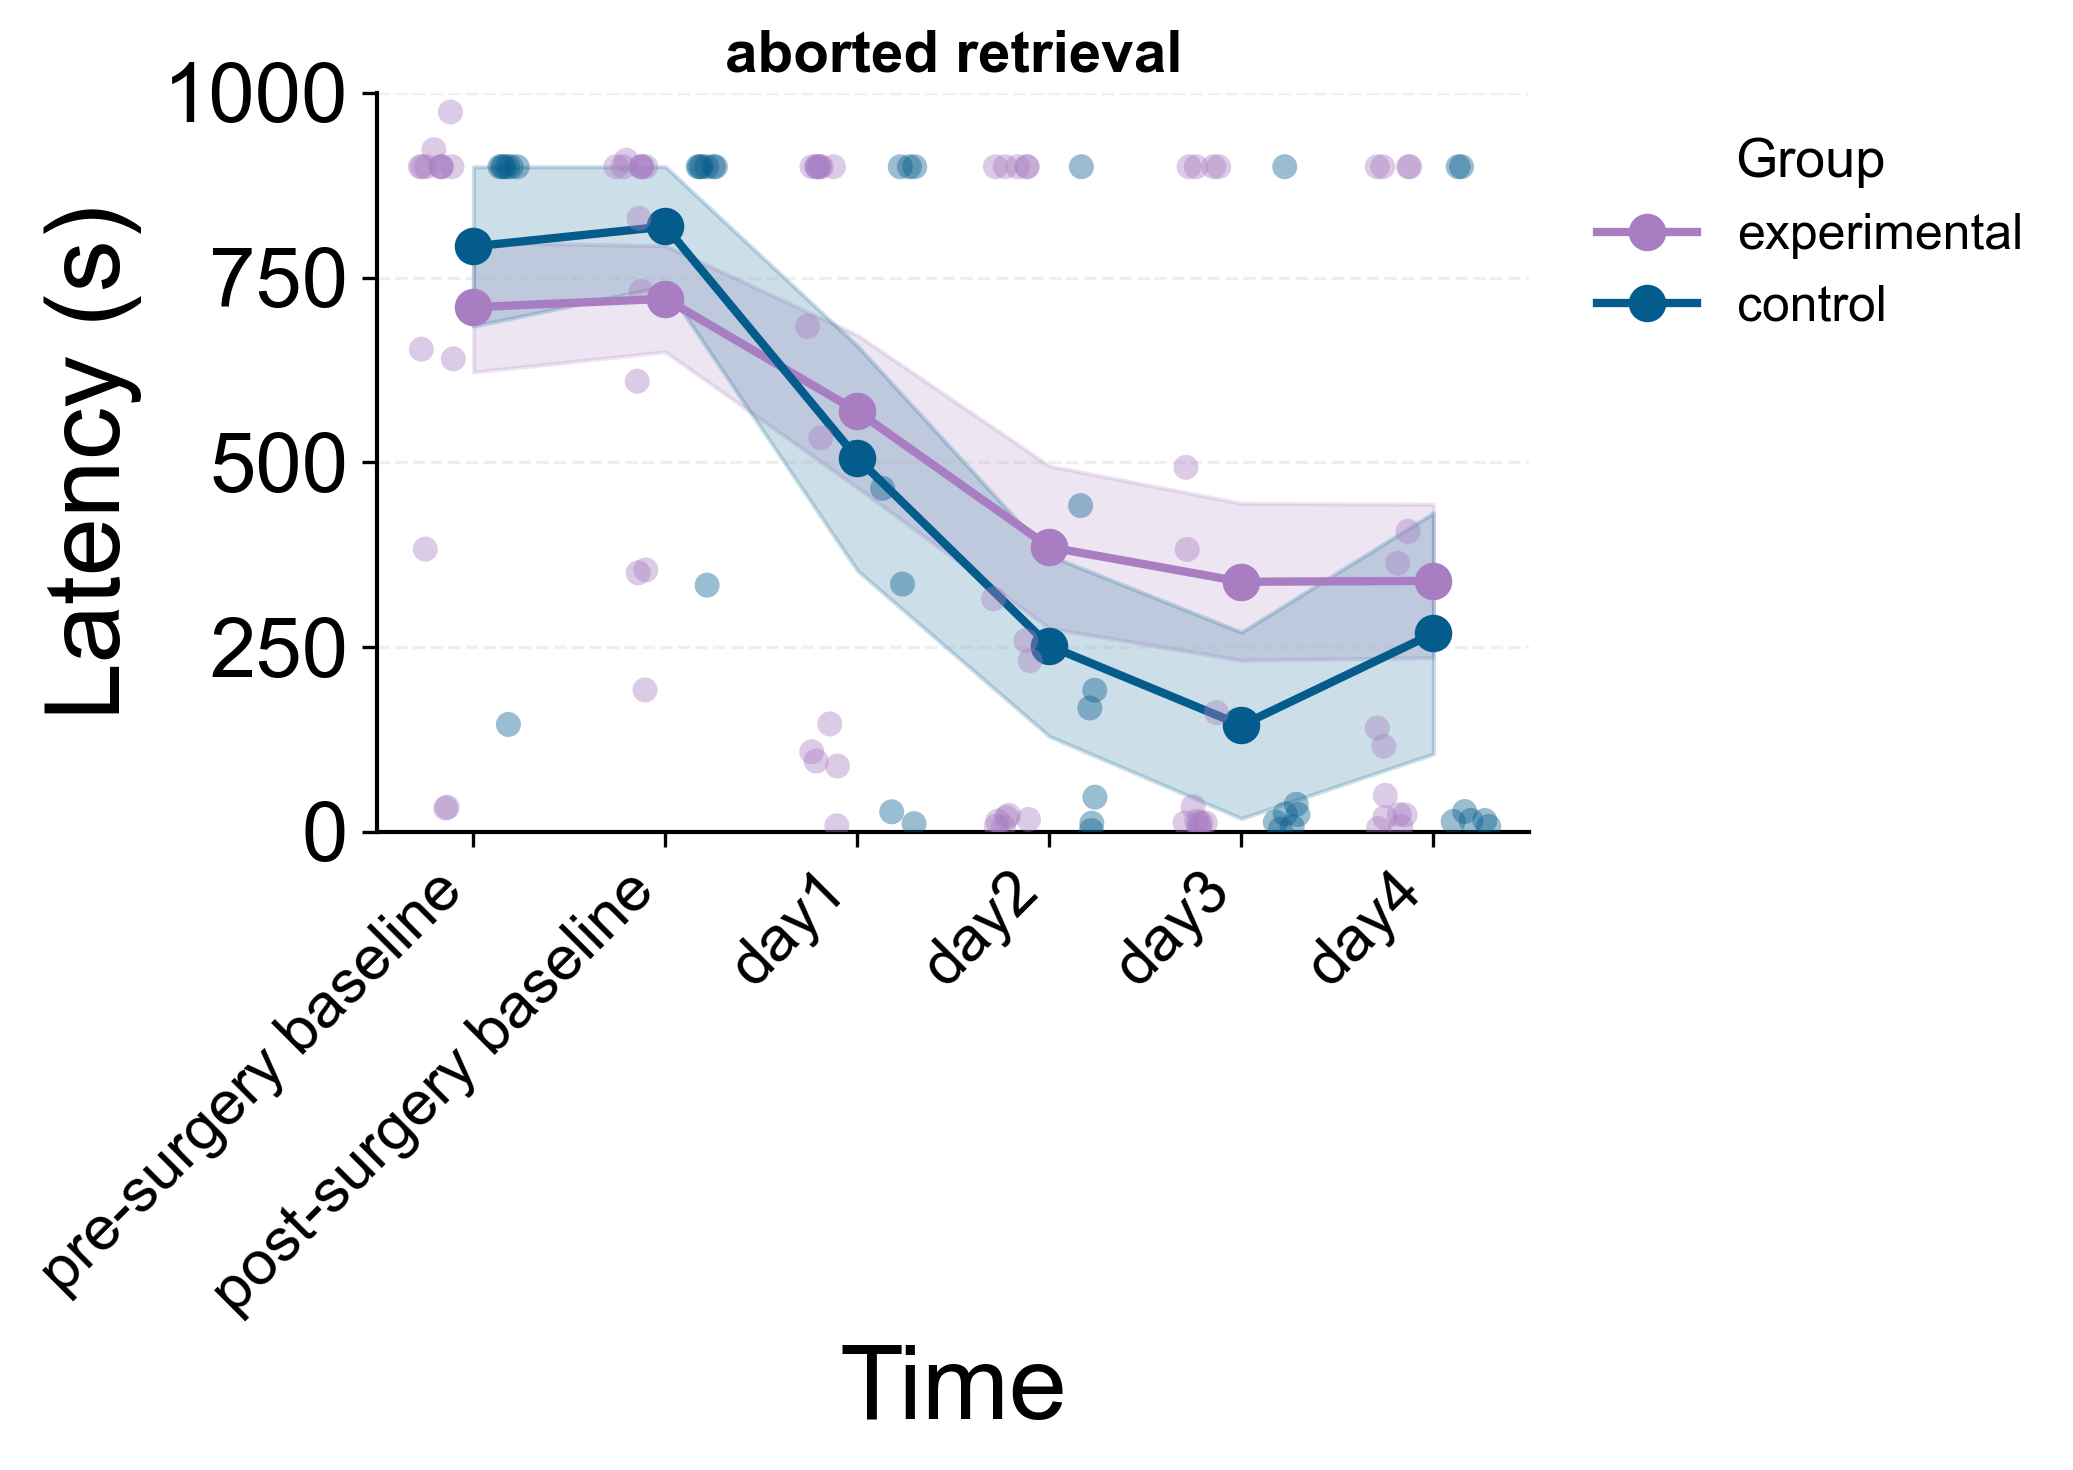

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


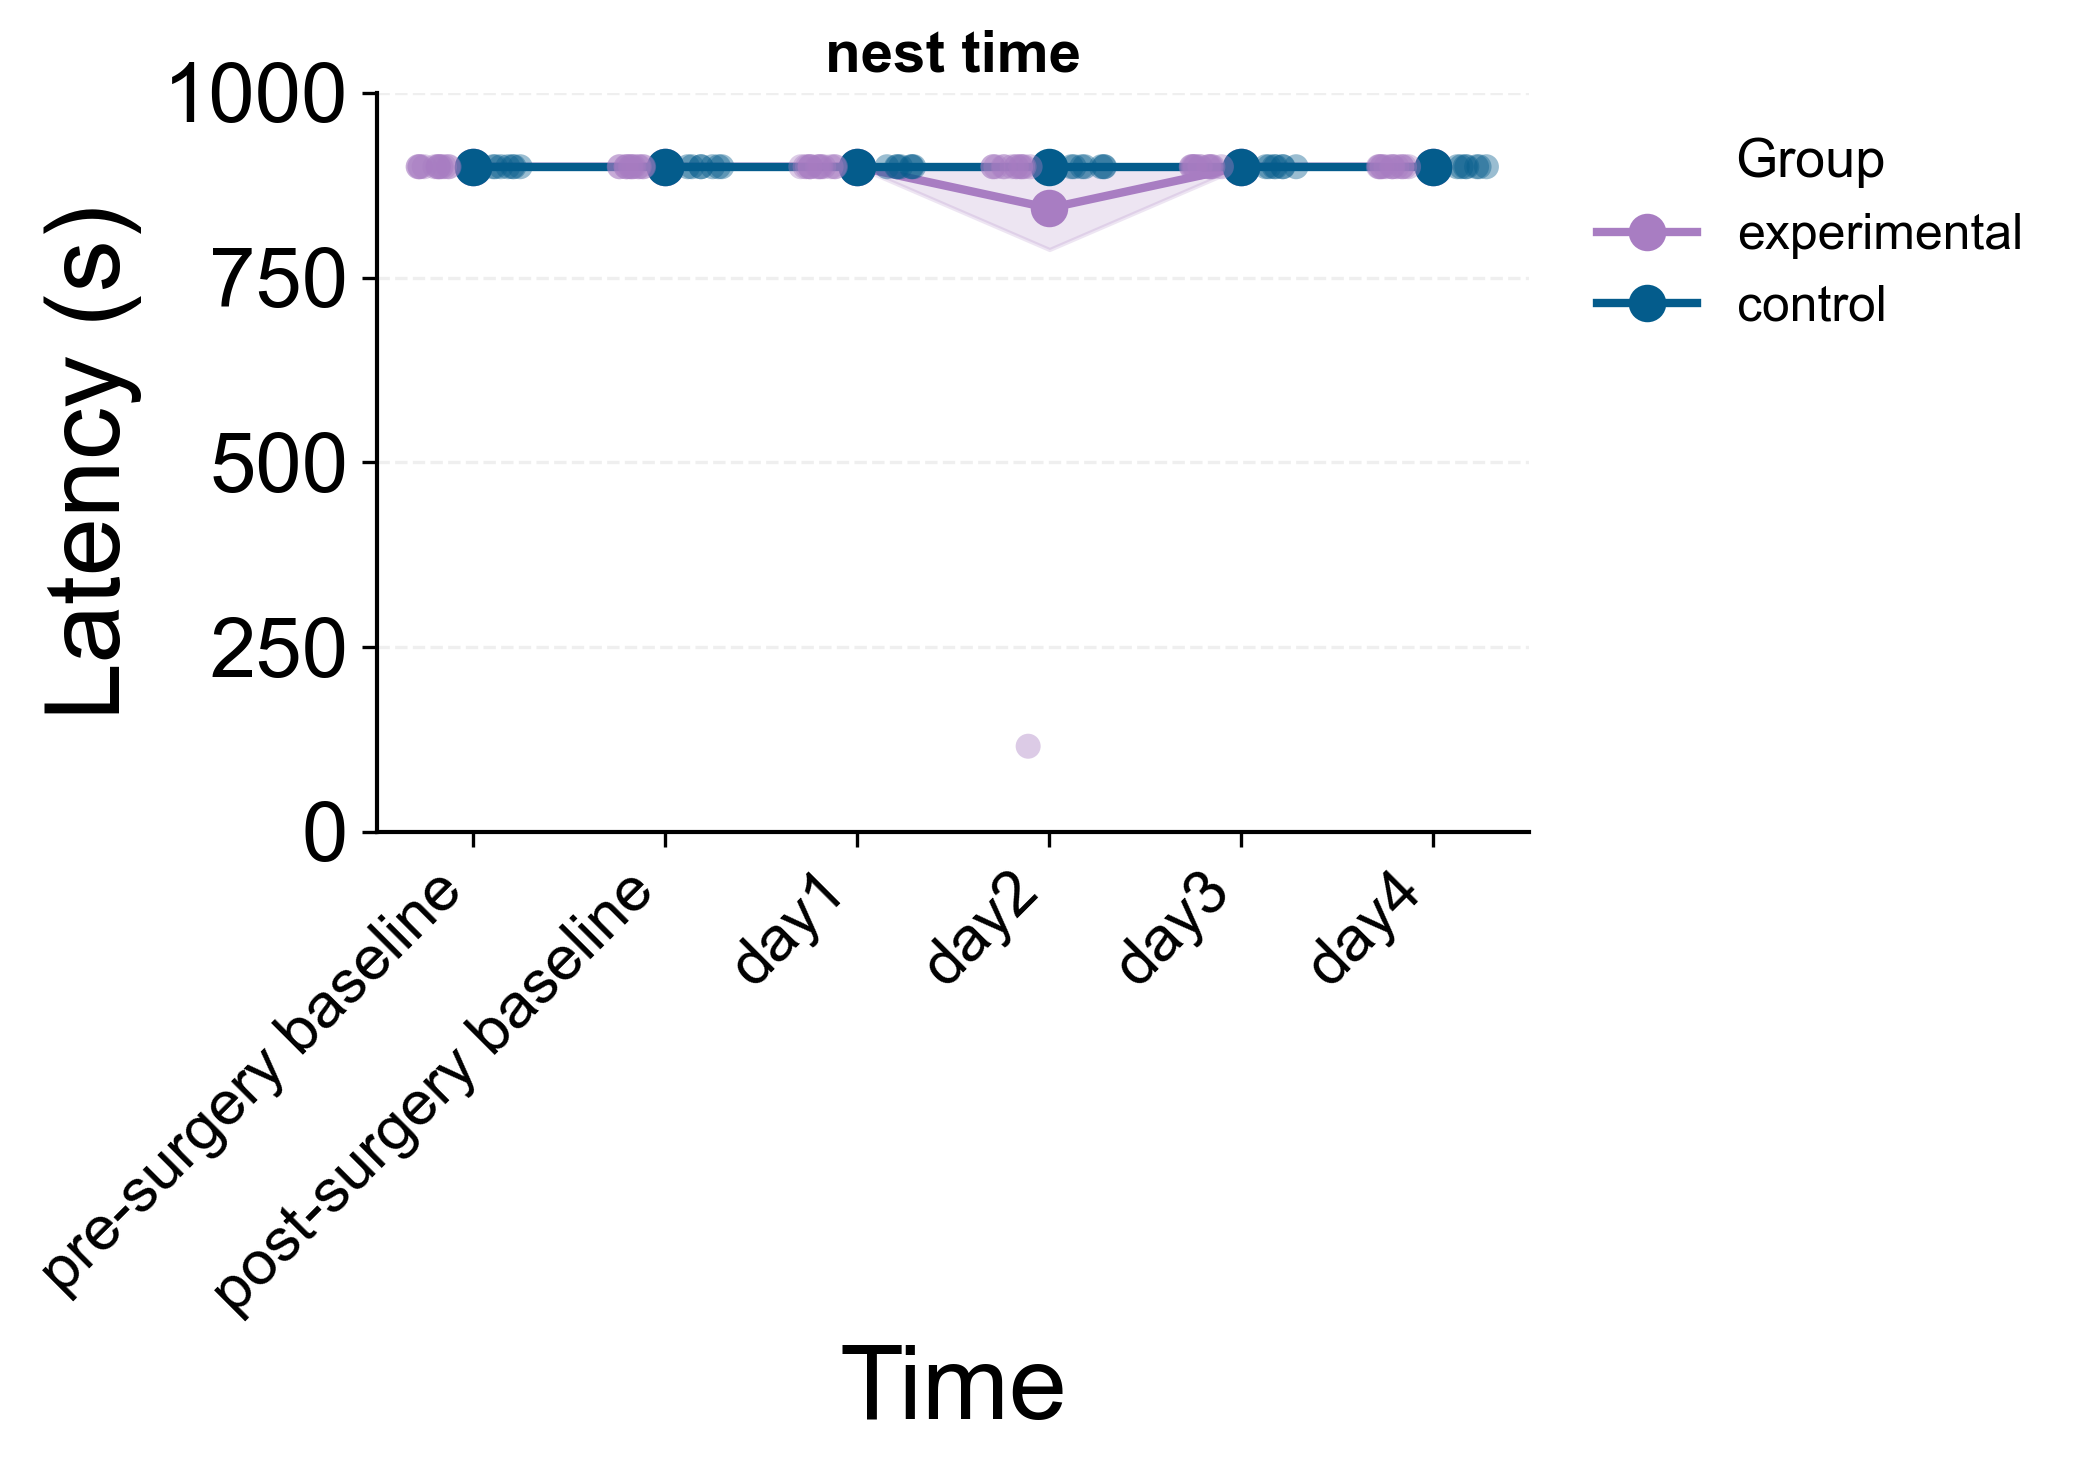

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


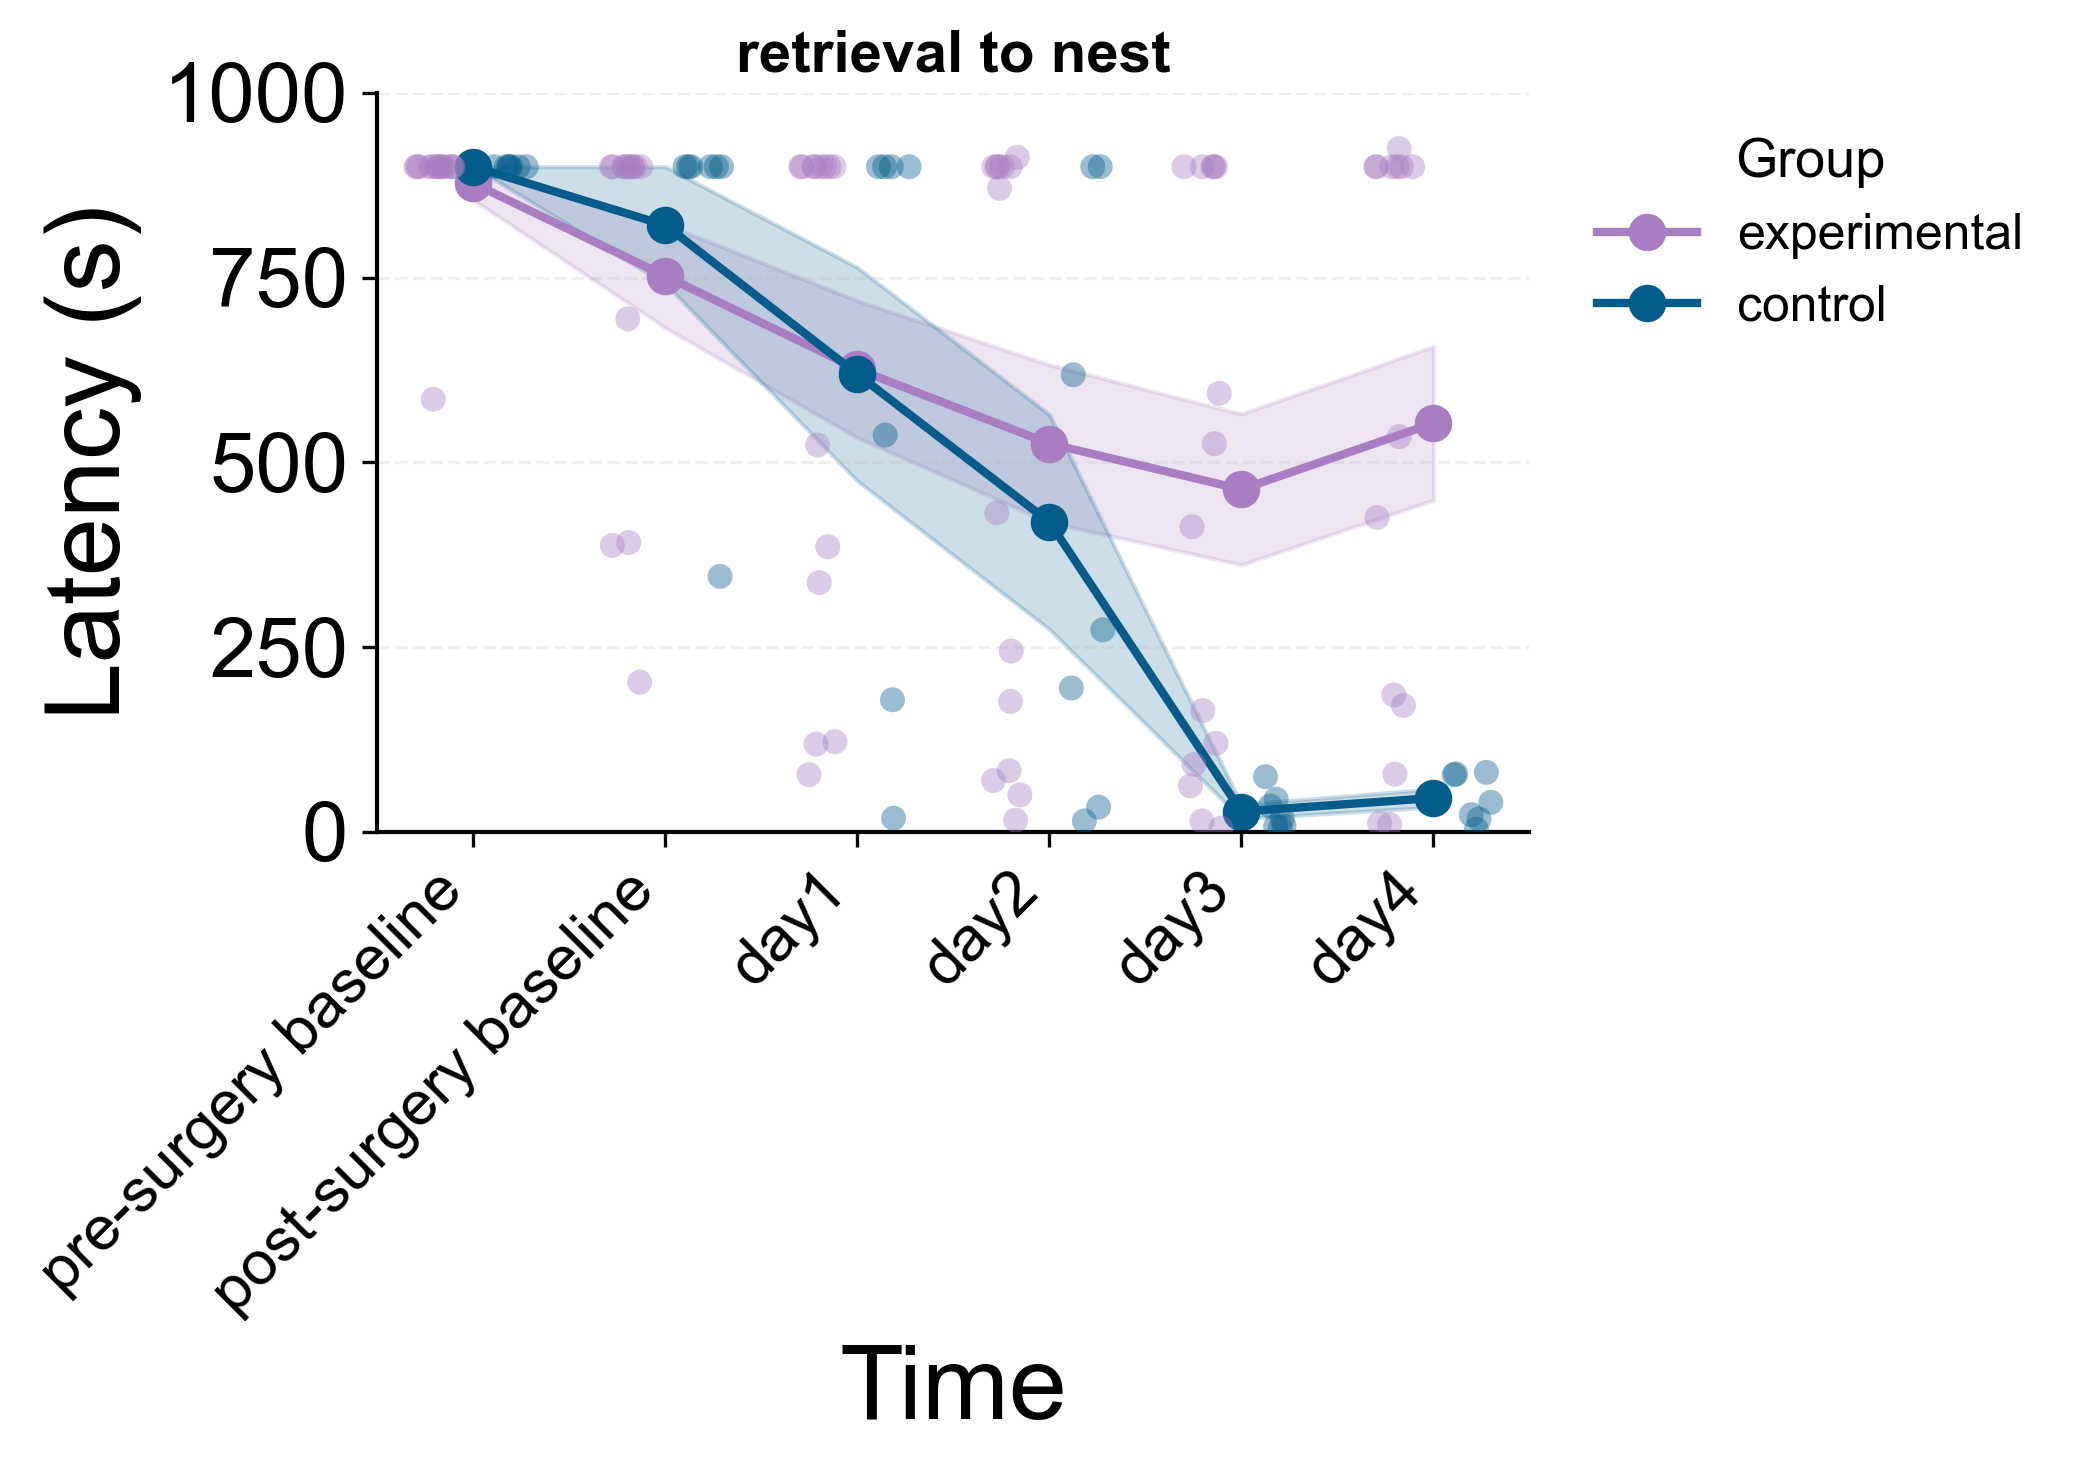

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


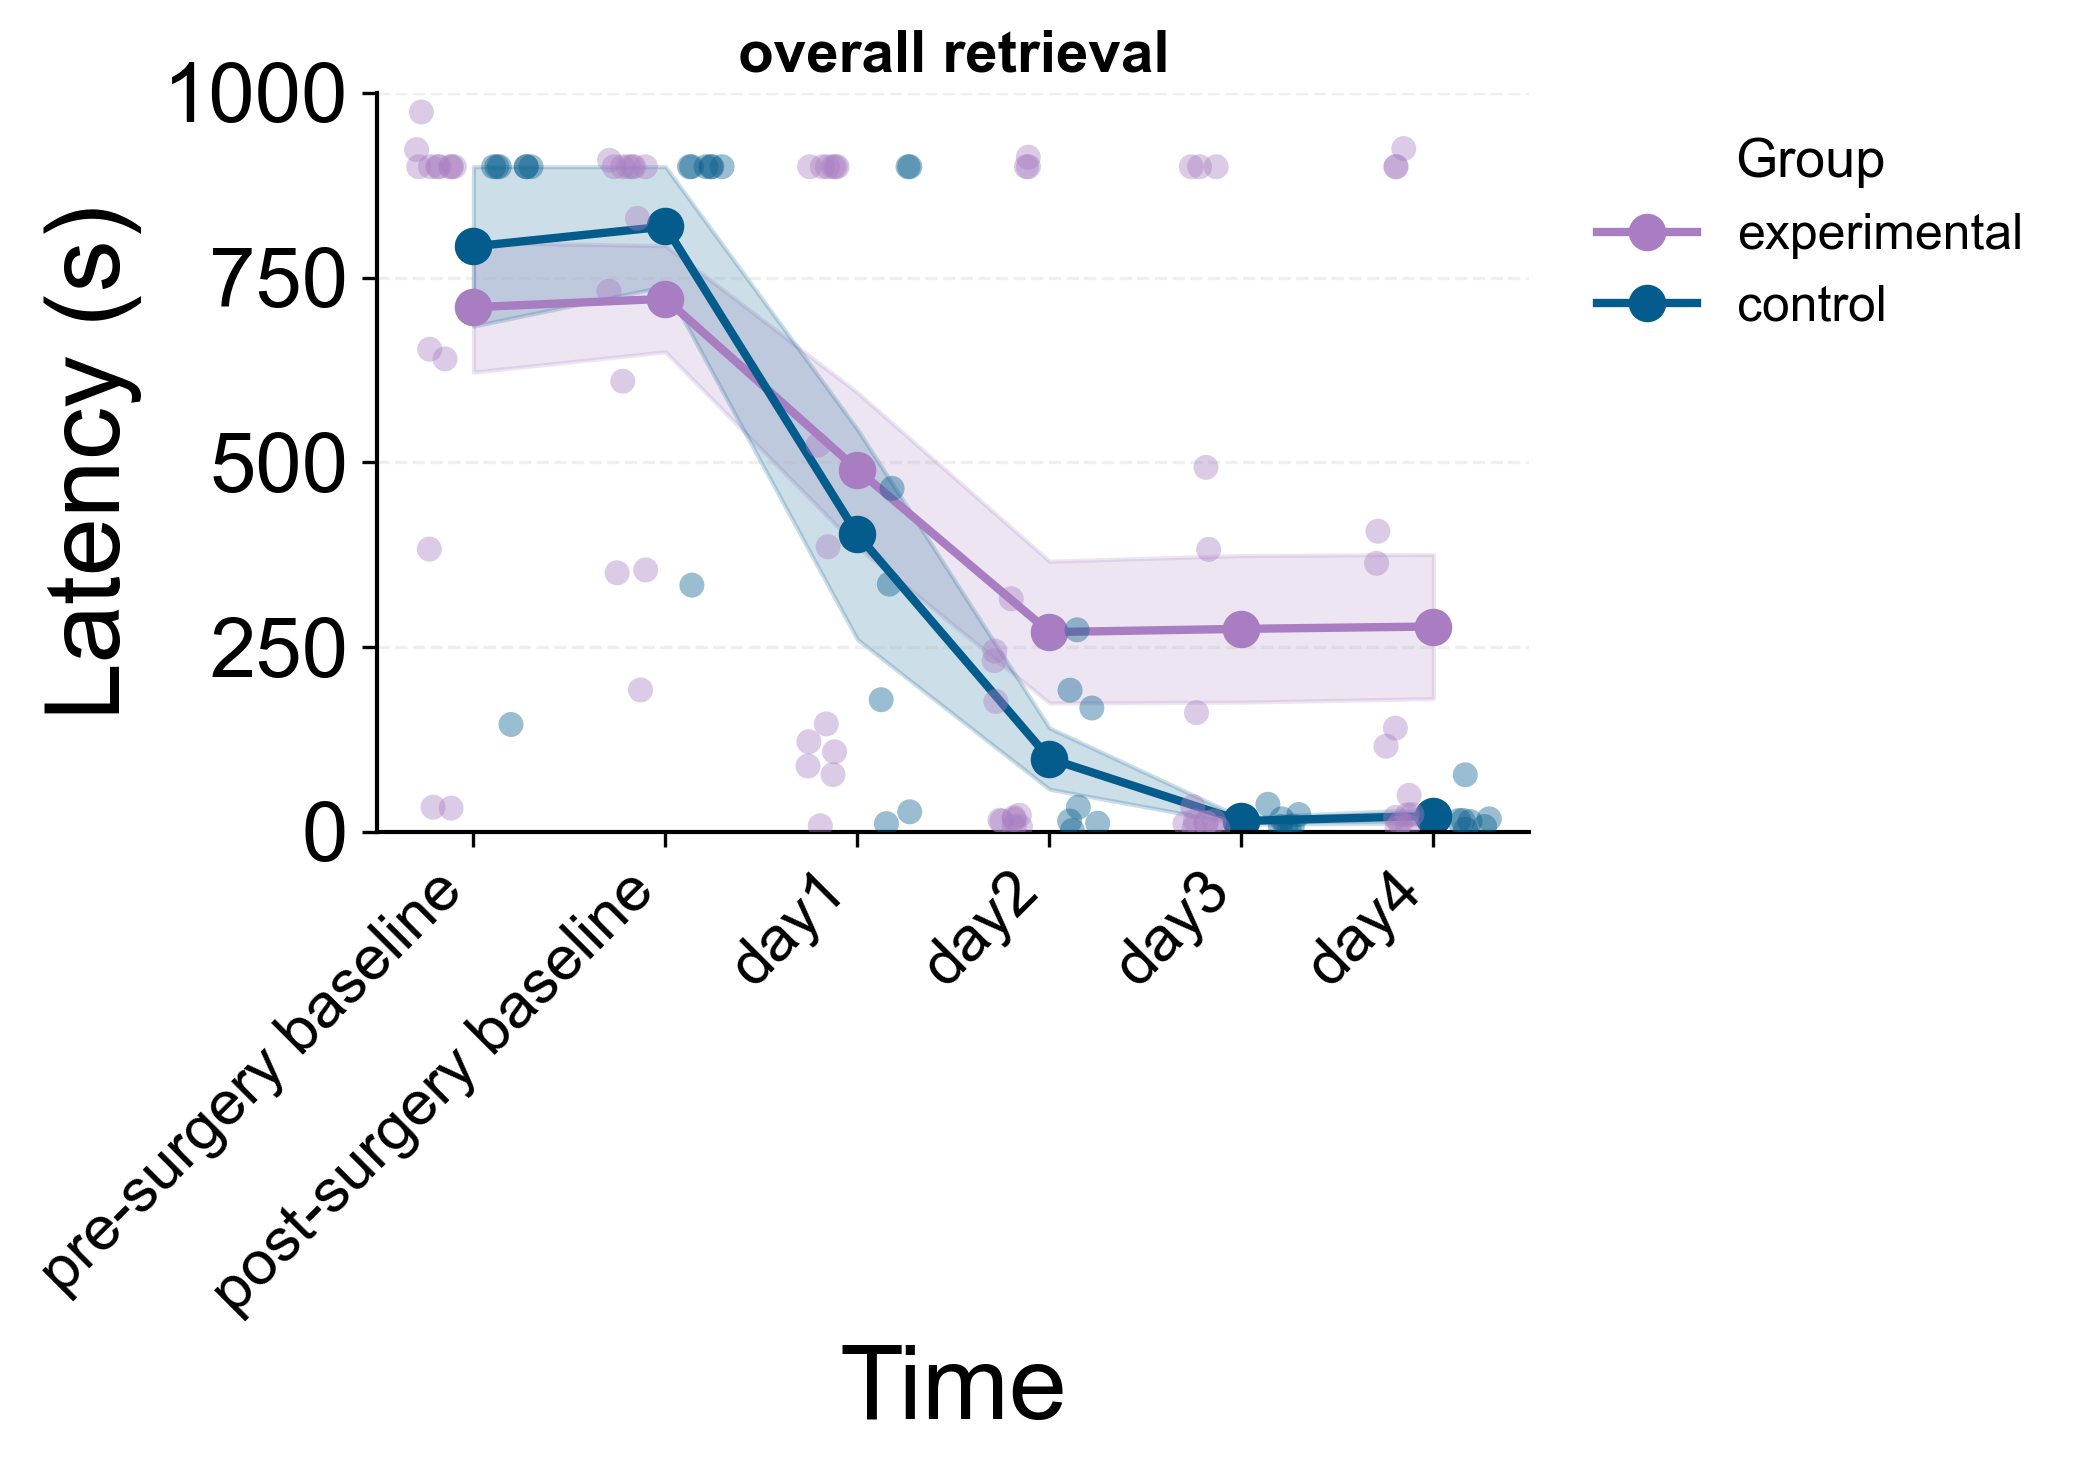

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


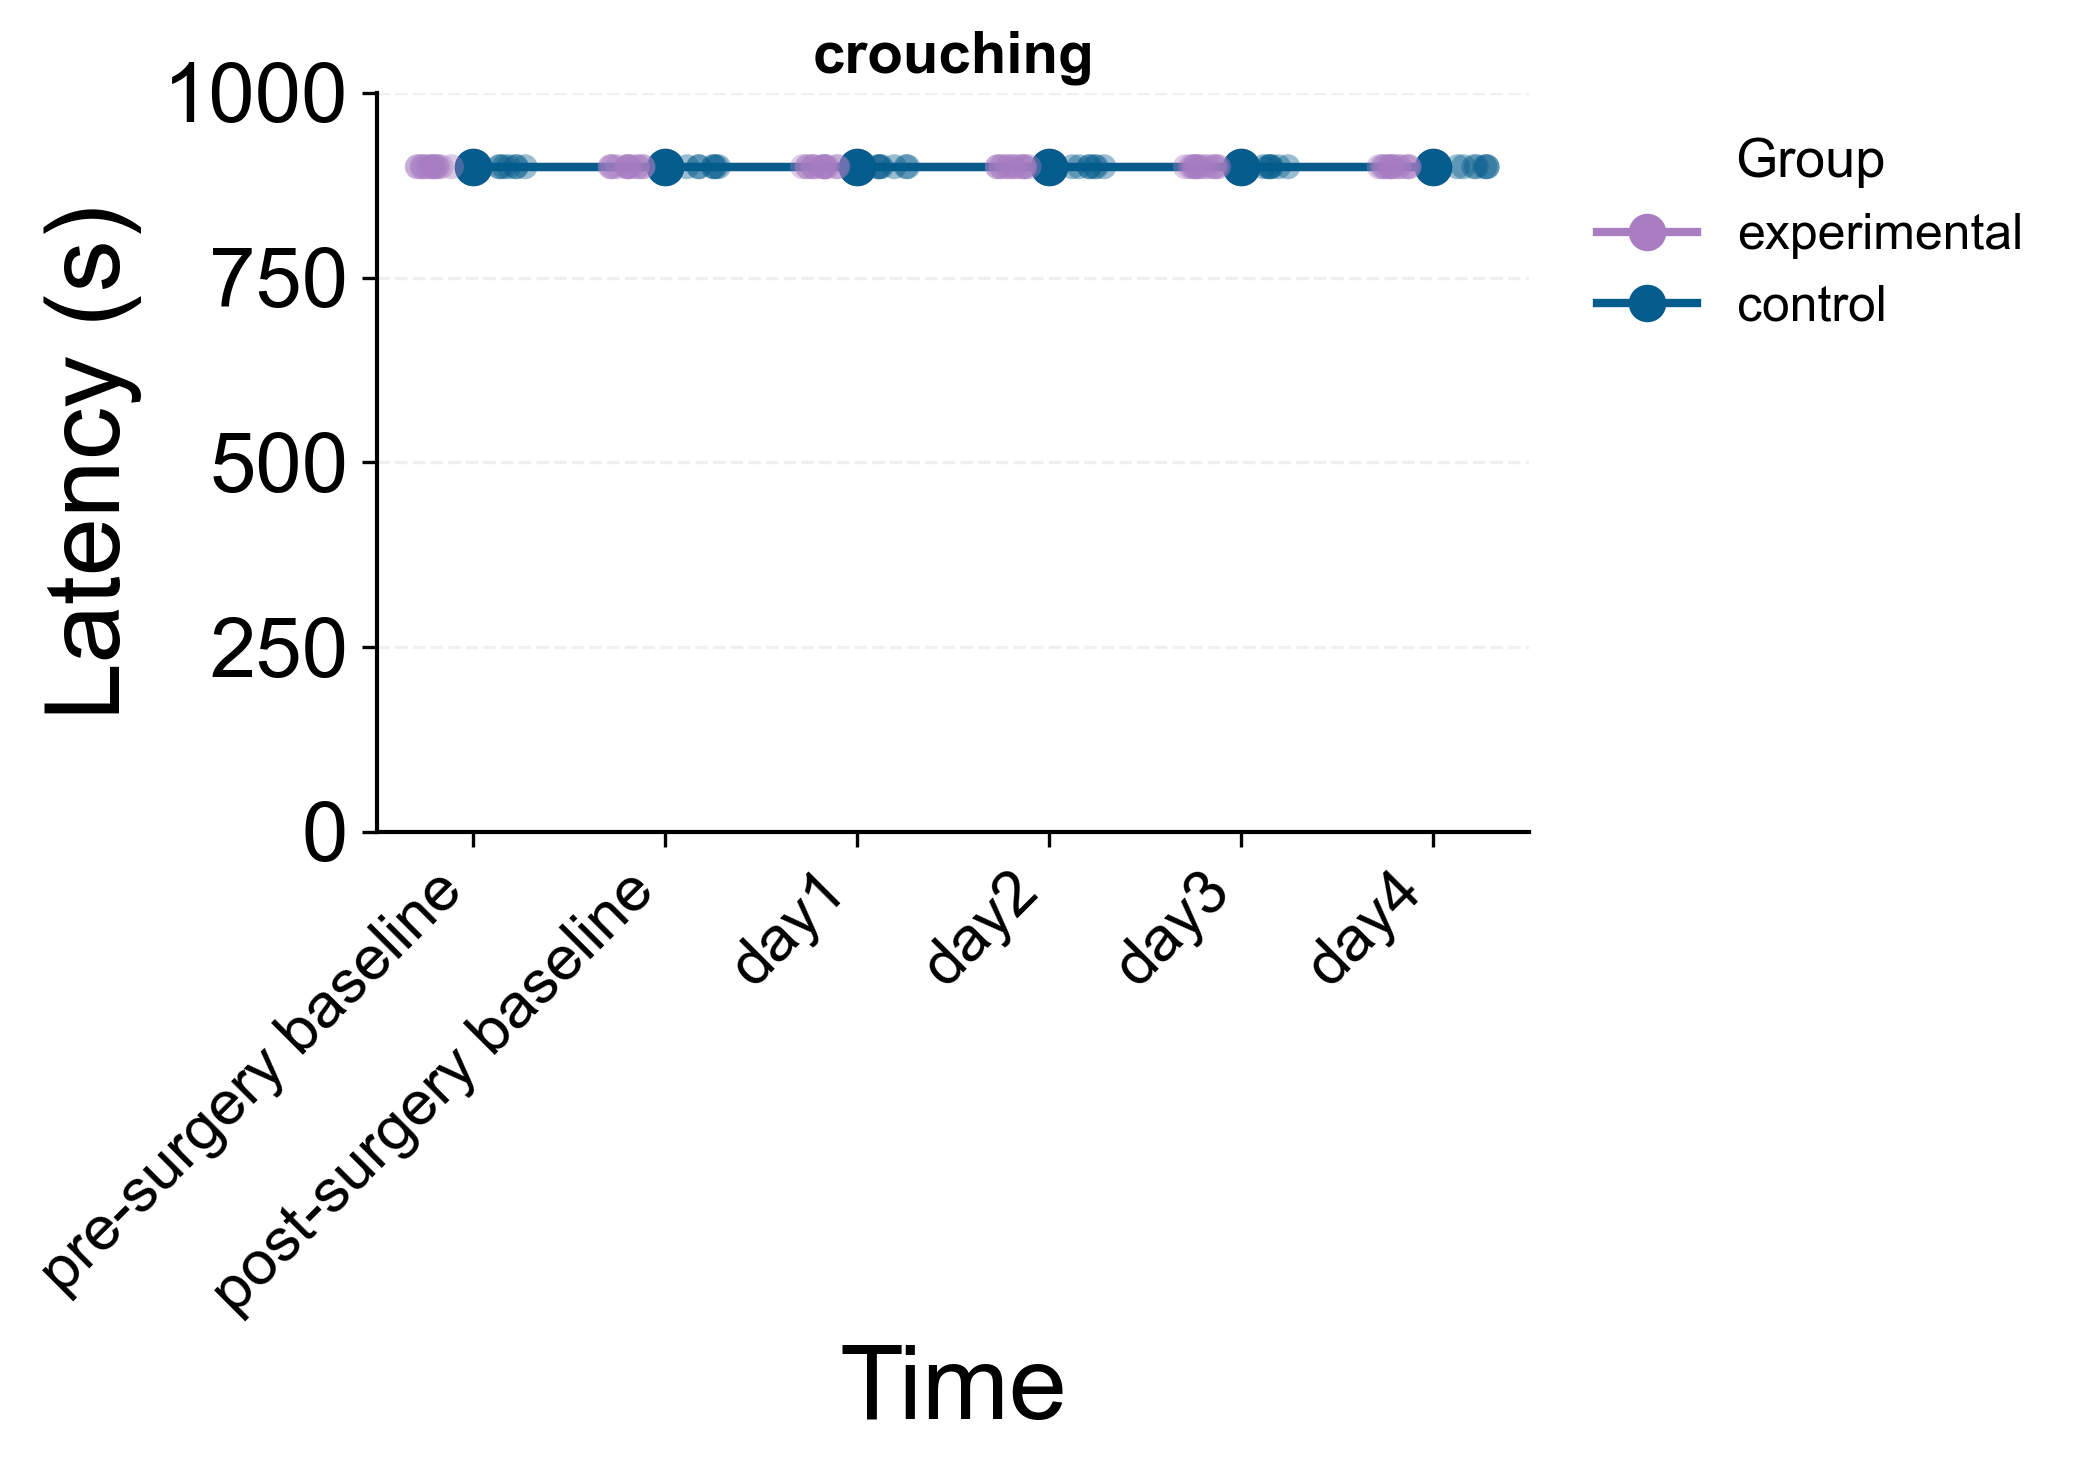

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_29103/961725424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


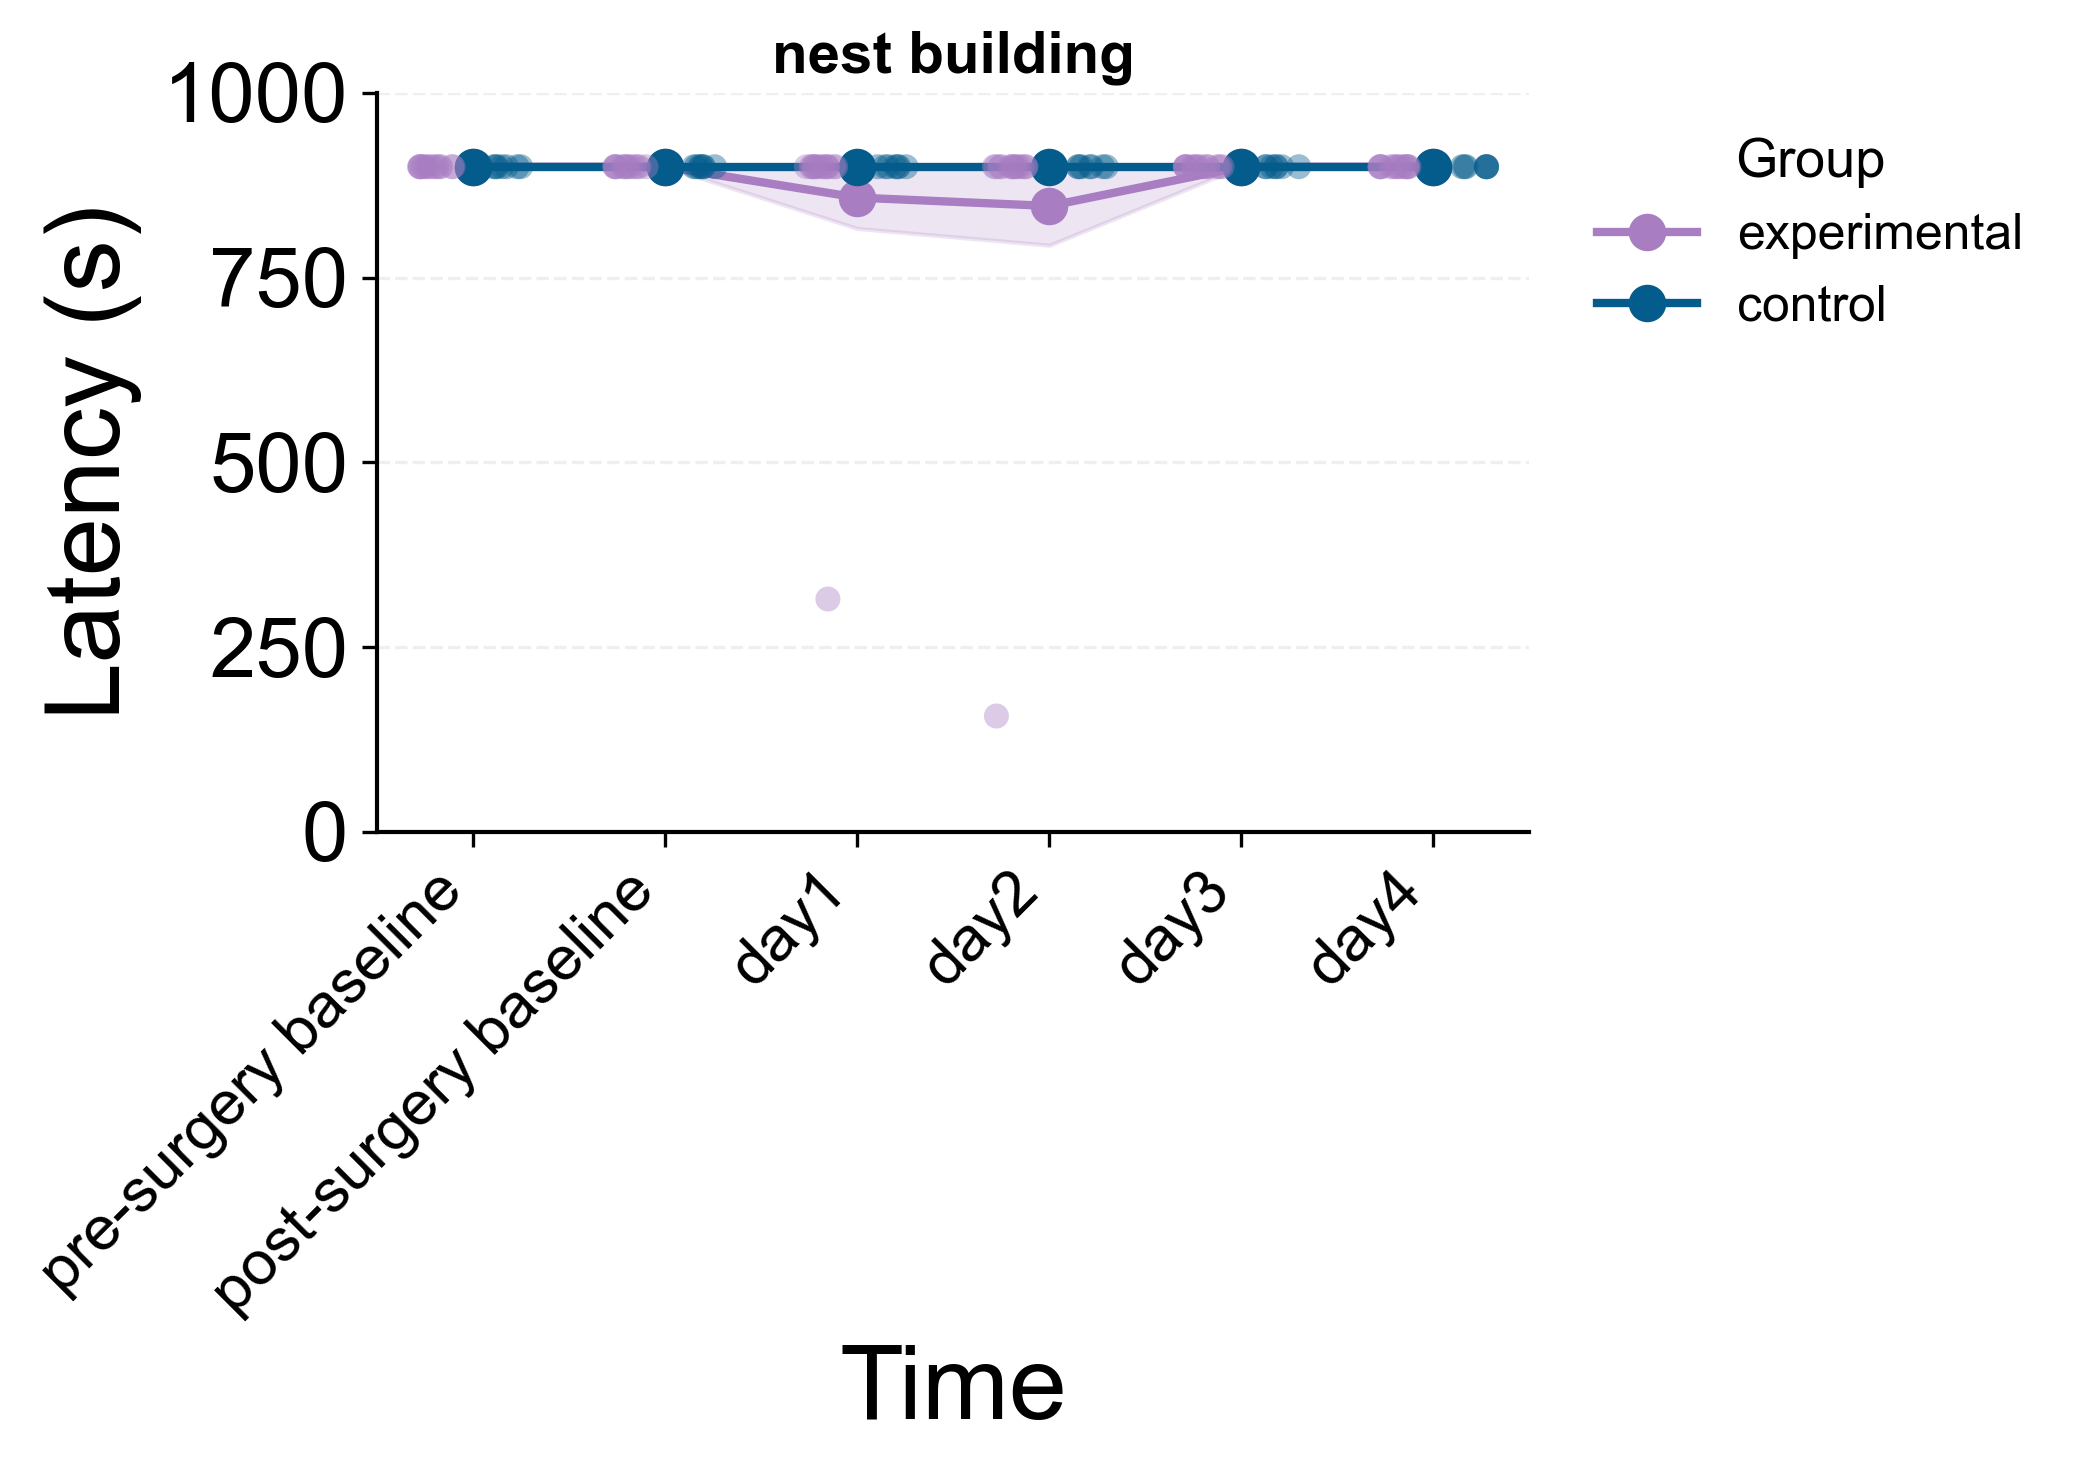

In [10]:
# Set publication-ready style parameters
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,  # Reduced font size for compact plots
    'axes.linewidth': 1,  # Thinner axes lines
    'axes.labelsize': 25,  # Smaller label size
    'axes.titlesize': 14,  # Smaller title size
    'xtick.labelsize': 15,  # Adjusted for longer labels
    'ytick.labelsize': 20,  # Smaller tick labels
    'figure.dpi': 300
})

for behaviour in behaviours.behaviour.unique():
    behav_df = behaviours[behaviours.behaviour == behaviour]
    
    # Convert to numeric if needed
    behav_df.latency = pd.to_numeric(behav_df.latency)
    
    # Rename time points for clarity
    behav_df = behav_df.copy()  # Create a copy to avoid SettingWithCopyWarning
    behav_df['time'] = behav_df['time'].replace({
        'baselinepre': 'pre-surgery baseline',
        'baselinepost': 'post-surgery baseline'
    })
    
    # Create figure with compact size
    fig, ax = plt.subplots(figsize=(6, 5))  # Slightly wider to accommodate labels
    
    # Add a subtle grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    
    # Define custom palette for groups using xkcd colors
    group_palette = {
        "experimental": "#a87dc2",  # wisteria from xkcd
        "control": "#045c8c"        # muted blue from xkcd
    }
    
    # Calculate means and standard errors for each group and time point
    # First create a summary dataframe
    summary = behav_df.groupby(['time', 'group'])['latency'].agg(['mean', 'sem']).reset_index()
    
    # Create lineplot for means with error bands
    for group in behav_df['group'].unique():
        group_data = summary[summary['group'] == group]
        
        # Plot the mean line
        plt.plot(group_data['time'], group_data['mean'], 'o-', 
                 color=group_palette[group], 
                 label=group,
                 linewidth=2, 
                 markersize=8)
        
        # Add error bands (SEM)
        plt.fill_between(group_data['time'], 
                         group_data['mean'] - group_data['sem'],
                         group_data['mean'] + group_data['sem'],
                         color=group_palette[group],
                         alpha=0.2)
    
    # Overlay individual data points with stripplot (removed the legend=False parameter)
    strip = sns.stripplot(x='time', y='latency', hue='group', data=behav_df,
                         palette=group_palette,
                         alpha=0.4,  # Lower alpha for the points
                         size=6,
                         dodge=True,  # Separate points by group
                         jitter=0.2,
                         linewidth=0)
    
    # Remove the stripplot legend
    if ax.get_legend():
        ax.get_legend().remove()
    
    # Set y-axis limits and tick marks every 250s
    ax.set_ylim([0, 1000])
    ax.set_yticks([0, 250, 500, 750, 1000])
    
    # Adjust labels for compact size
    plt.ylabel('Latency (s)', labelpad=5)
    plt.xlabel('Time', labelpad=5)  # Empty xlabel
    
    # Add title with minimal spacing
    plt.title(behaviour, pad=5, fontweight='bold')
    
    # Rotate x-tick labels for better readability with long labels
    plt.xticks(rotation=45, ha='right')
    
    # Custom legend from the line plot
    handles, labels = ax.get_legend_handles_labels()
    # Keep only the first set of handles (from lineplot)
    handles = handles[:2]  
    labels = labels[:2]
    # Position legend outside plot area
    ax.legend(handles, labels, title="Group", loc='upper left', bbox_to_anchor=(1.02, 1), 
              frameon=False, fontsize=12, title_fontsize=13)
    
    # Remove unnecessary spines
    sns.despine()
    
    # Adjust figure size to accommodate legend
    fig.tight_layout()
    # Add extra space for the legend
    plt.subplots_adjust(right=0.85)
    
    # Save figures in publication-ready formats
    plt.savefig(f'plots_chem_bnst/{behaviour}_latency_line.png', dpi=500, bbox_inches='tight')
    
    plt.show()

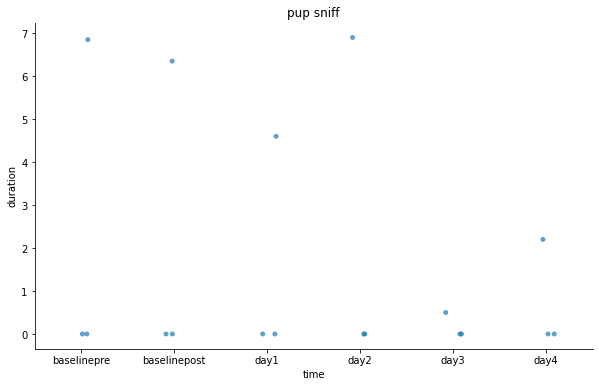

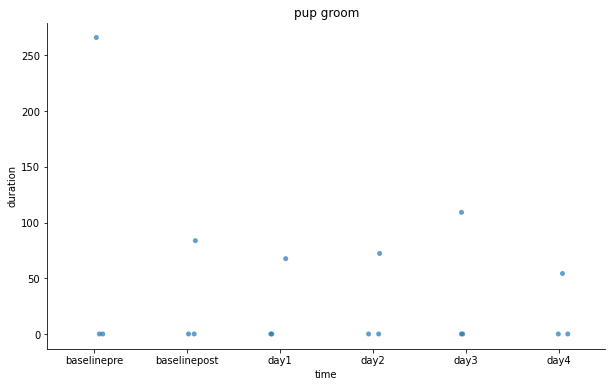

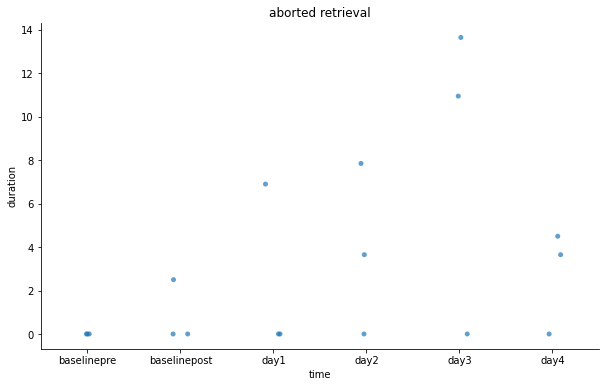

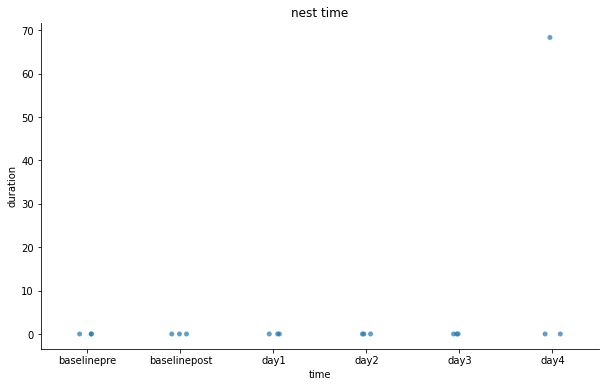

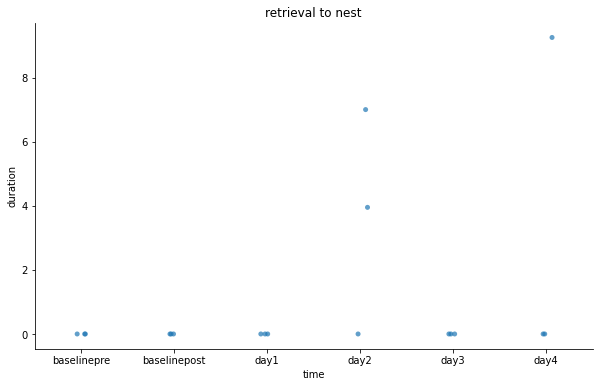

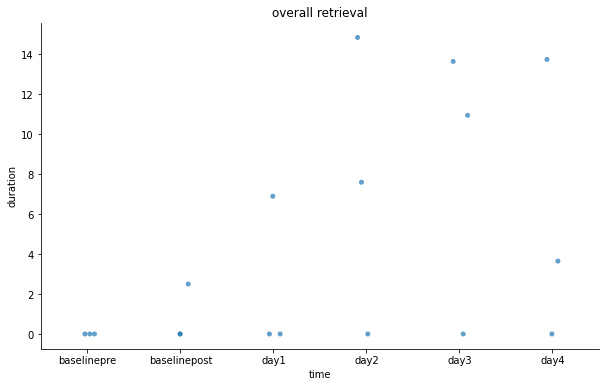

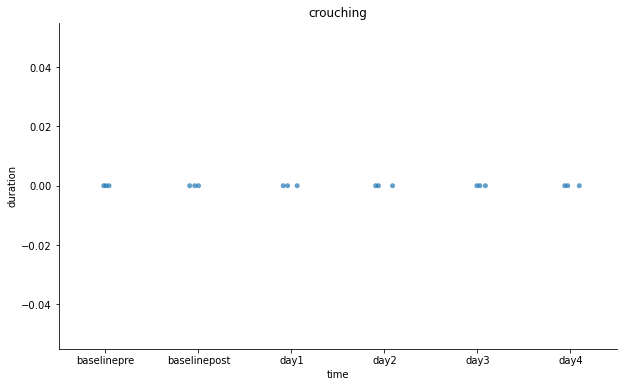

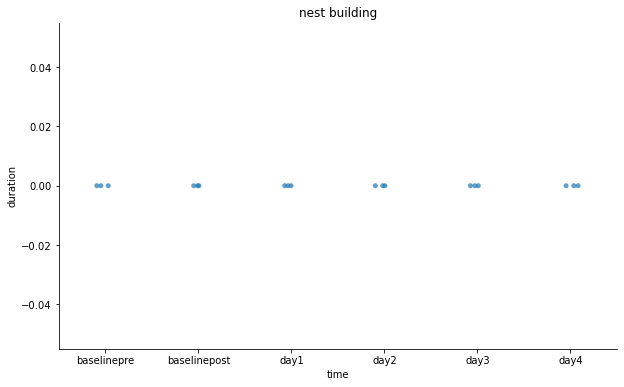

In [10]:
for behaviour in behaviours.behaviour.unique():
    behav_df = behaviours[behaviours.behaviour == behaviour]
    
    plt.subplots(figsize = [10,6])
    sns.stripplot(x = "time", y = "duration", data = behav_df, palette = ["Tab:blue"], alpha = 0.7)
    plt.title(behaviour)
    sns.despine()
    # plt.savefig(f'plots_chem_mea/{behaviour}_duration.jpg', dpi = 300, bbox_inches = 'tight')
    plt.show()

            time  behaviour         group percentage
0    baselinepre  pup sniff  experimental   0.076923
1    baselinepre  pup sniff       control        0.0
16  baselinepost  pup sniff  experimental   0.083333
17  baselinepost  pup sniff       control        0.0
32          day1  pup sniff  experimental   0.076923
33          day1  pup sniff       control        0.0
48          day2  pup sniff  experimental   0.076923
49          day2  pup sniff       control        0.0
64          day3  pup sniff  experimental        0.0
65          day3  pup sniff       control        0.0
80          day4  pup sniff  experimental        0.0
81          day4  pup sniff       control        0.0


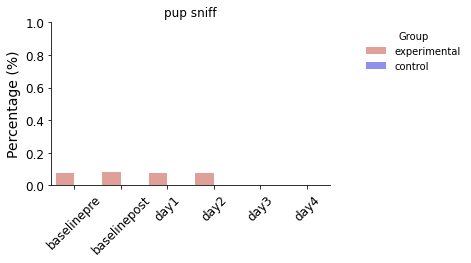

            time  behaviour         group percentage
2    baselinepre  pup groom  experimental   0.076923
3    baselinepre  pup groom       control        0.0
18  baselinepost  pup groom  experimental   0.083333
19  baselinepost  pup groom       control        0.0
34          day1  pup groom  experimental   0.076923
35          day1  pup groom       control        0.0
50          day2  pup groom  experimental   0.076923
51          day2  pup groom       control        0.0
66          day3  pup groom  experimental        0.0
67          day3  pup groom       control        0.0
82          day4  pup groom  experimental        0.0
83          day4  pup groom       control        0.0


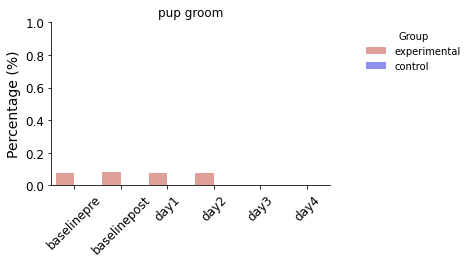

            time          behaviour         group percentage
4    baselinepre  aborted retrieval  experimental   0.538462
5    baselinepre  aborted retrieval       control   0.166667
20  baselinepost  aborted retrieval  experimental        0.5
21  baselinepost  aborted retrieval       control   0.142857
36          day1  aborted retrieval  experimental   0.461538
37          day1  aborted retrieval       control   0.571429
52          day2  aborted retrieval  experimental   0.692308
53          day2  aborted retrieval       control   0.857143
68          day3  aborted retrieval  experimental   0.769231
69          day3  aborted retrieval       control   0.857143
84          day4  aborted retrieval  experimental   0.692308
85          day4  aborted retrieval       control   0.714286


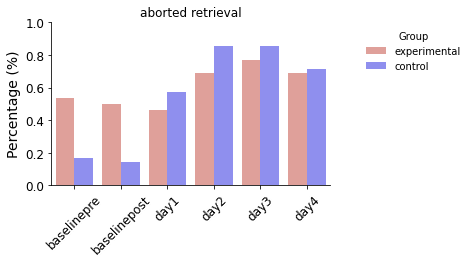

            time  behaviour         group percentage
6    baselinepre  nest time  experimental        0.0
7    baselinepre  nest time       control        0.0
22  baselinepost  nest time  experimental        0.0
23  baselinepost  nest time       control        0.0
38          day1  nest time  experimental        0.0
39          day1  nest time       control        0.0
54          day2  nest time  experimental   0.076923
55          day2  nest time       control        0.0
70          day3  nest time  experimental        0.0
71          day3  nest time       control        0.0
86          day4  nest time  experimental        0.0
87          day4  nest time       control        0.0


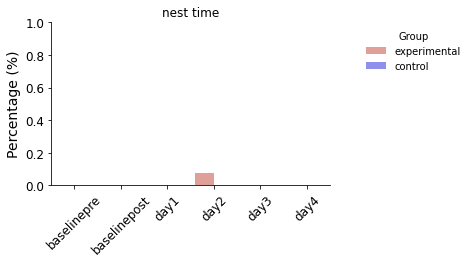

            time          behaviour         group percentage
8    baselinepre  retrieval to nest  experimental   0.076923
9    baselinepre  retrieval to nest       control        0.0
24  baselinepost  retrieval to nest  experimental   0.333333
25  baselinepost  retrieval to nest       control   0.142857
40          day1  retrieval to nest  experimental   0.384615
41          day1  retrieval to nest       control   0.428571
56          day2  retrieval to nest  experimental   0.692308
57          day2  retrieval to nest       control   0.714286
72          day3  retrieval to nest  experimental   0.692308
73          day3  retrieval to nest       control        1.0
88          day4  retrieval to nest  experimental   0.538462
89          day4  retrieval to nest       control        1.0


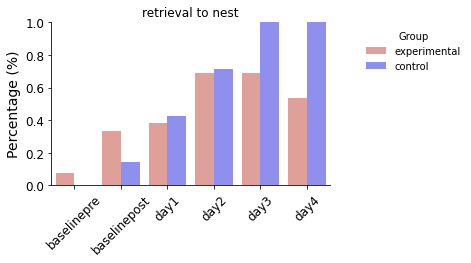

            time          behaviour         group percentage
10   baselinepre  overall retrieval  experimental   0.538462
11   baselinepre  overall retrieval       control   0.166667
26  baselinepost  overall retrieval  experimental        0.5
27  baselinepost  overall retrieval       control   0.142857
42          day1  overall retrieval  experimental   0.538462
43          day1  overall retrieval       control   0.714286
58          day2  overall retrieval  experimental   0.923077
59          day2  overall retrieval       control        1.0
74          day3  overall retrieval  experimental   0.846154
75          day3  overall retrieval       control        1.0
90          day4  overall retrieval  experimental   0.846154
91          day4  overall retrieval       control        1.0


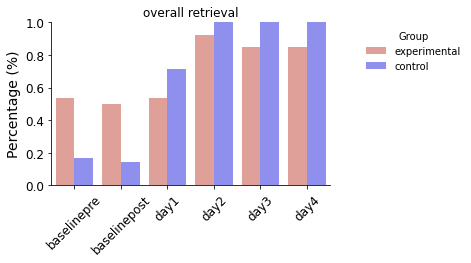

            time  behaviour         group percentage
12   baselinepre  crouching  experimental        0.0
13   baselinepre  crouching       control        0.0
28  baselinepost  crouching  experimental        0.0
29  baselinepost  crouching       control        0.0
44          day1  crouching  experimental        0.0
45          day1  crouching       control        0.0
60          day2  crouching  experimental        0.0
61          day2  crouching       control        0.0
76          day3  crouching  experimental        0.0
77          day3  crouching       control        0.0
92          day4  crouching  experimental        0.0
93          day4  crouching       control        0.0


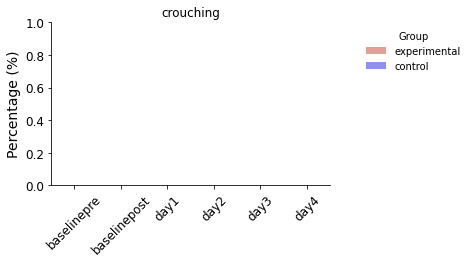

            time      behaviour         group percentage
14   baselinepre  nest building  experimental        0.0
15   baselinepre  nest building       control        0.0
30  baselinepost  nest building  experimental        0.0
31  baselinepost  nest building       control        0.0
46          day1  nest building  experimental   0.076923
47          day1  nest building       control        0.0
62          day2  nest building  experimental   0.076923
63          day2  nest building       control        0.0
78          day3  nest building  experimental        0.0
79          day3  nest building       control        0.0
94          day4  nest building  experimental        0.0
95          day4  nest building       control        0.0


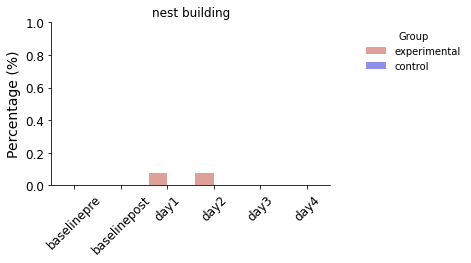

In [6]:
for behaviour in percentages.behaviour.unique():
    perc_df = percentages[percentages.behaviour == behaviour]
    print(perc_df)
    
    fig, ax = plt.subplots(figsize = [5, 3])

    # define custom palette for the two groups
    custom_palette = {"experimental": "#d7301f", "control": "blue"}

    sns.barplot(x = "time", y = "percentage", data = perc_df, hue= 'group', palette = custom_palette, alpha = 0.5)
    plt.title(behaviour)
    
    plt.ylim([0, 1])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xticks(rotation = 45)
    
    plt.xlabel('')
    plt.ylabel('Percentage (%)',fontsize = 14)

    # adjust legend position
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Group", loc='upper right', bbox_to_anchor=(1.5, 1), frameon=False)
    
    sns.despine()
    # plt.savefig(f'plots_chem_bnst/{behaviour}_percentage.jpg', dpi = 300)
    plt.show()

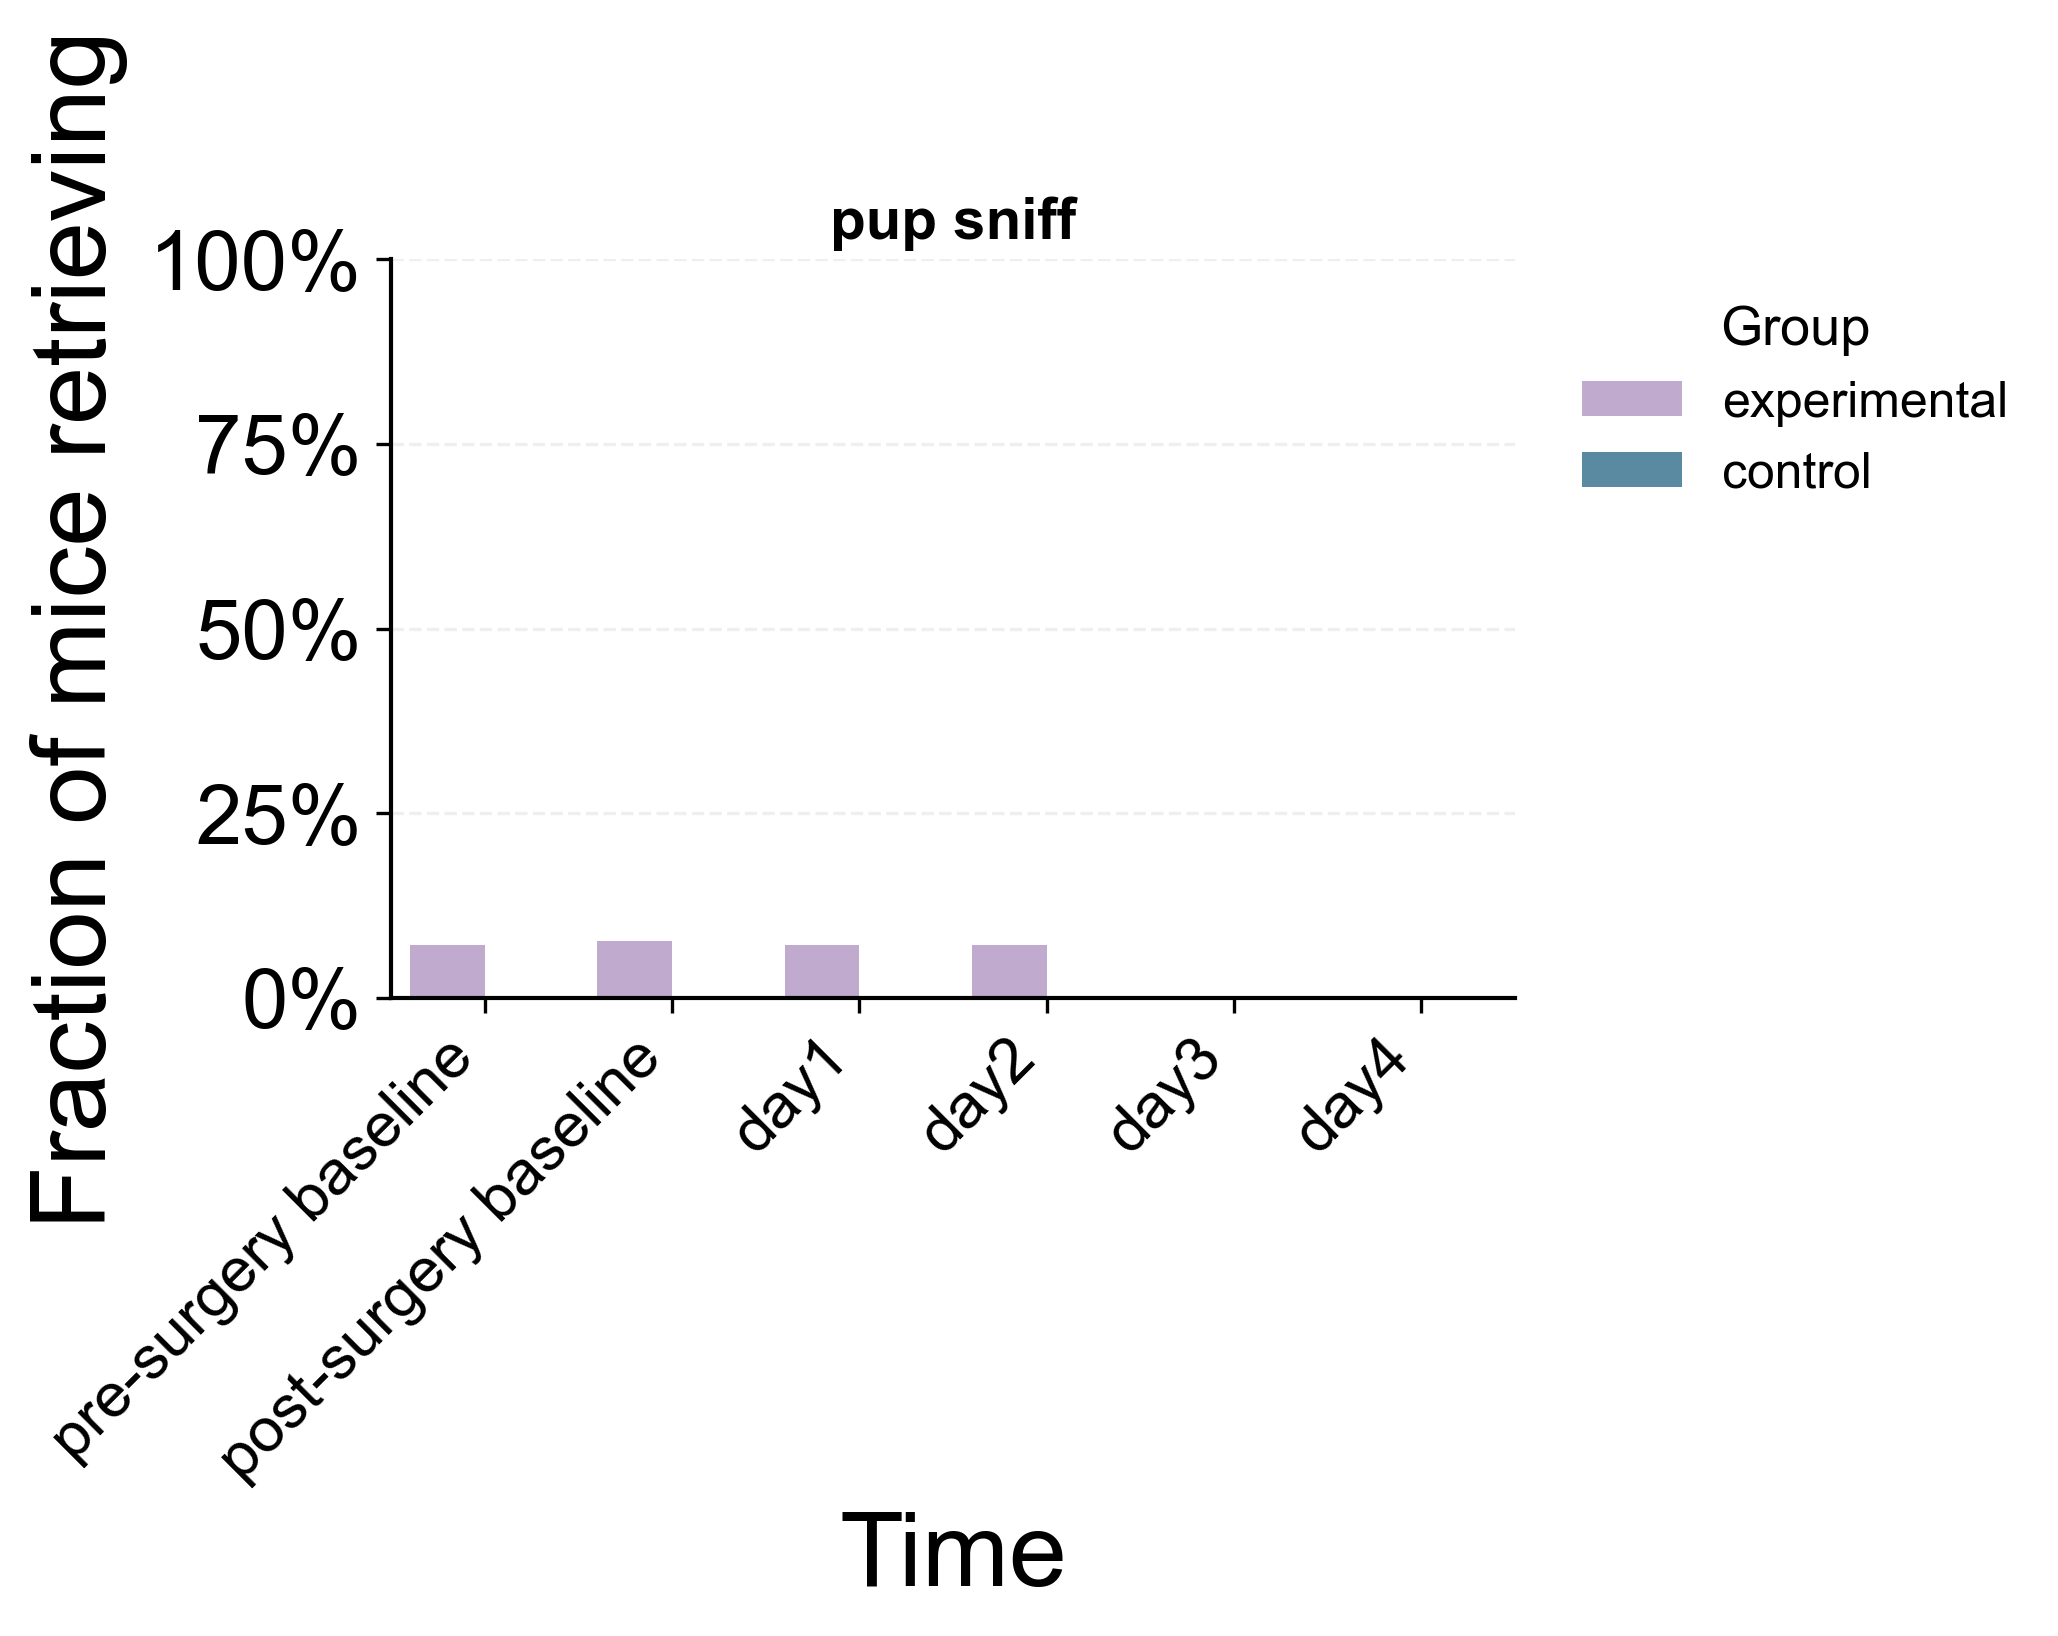

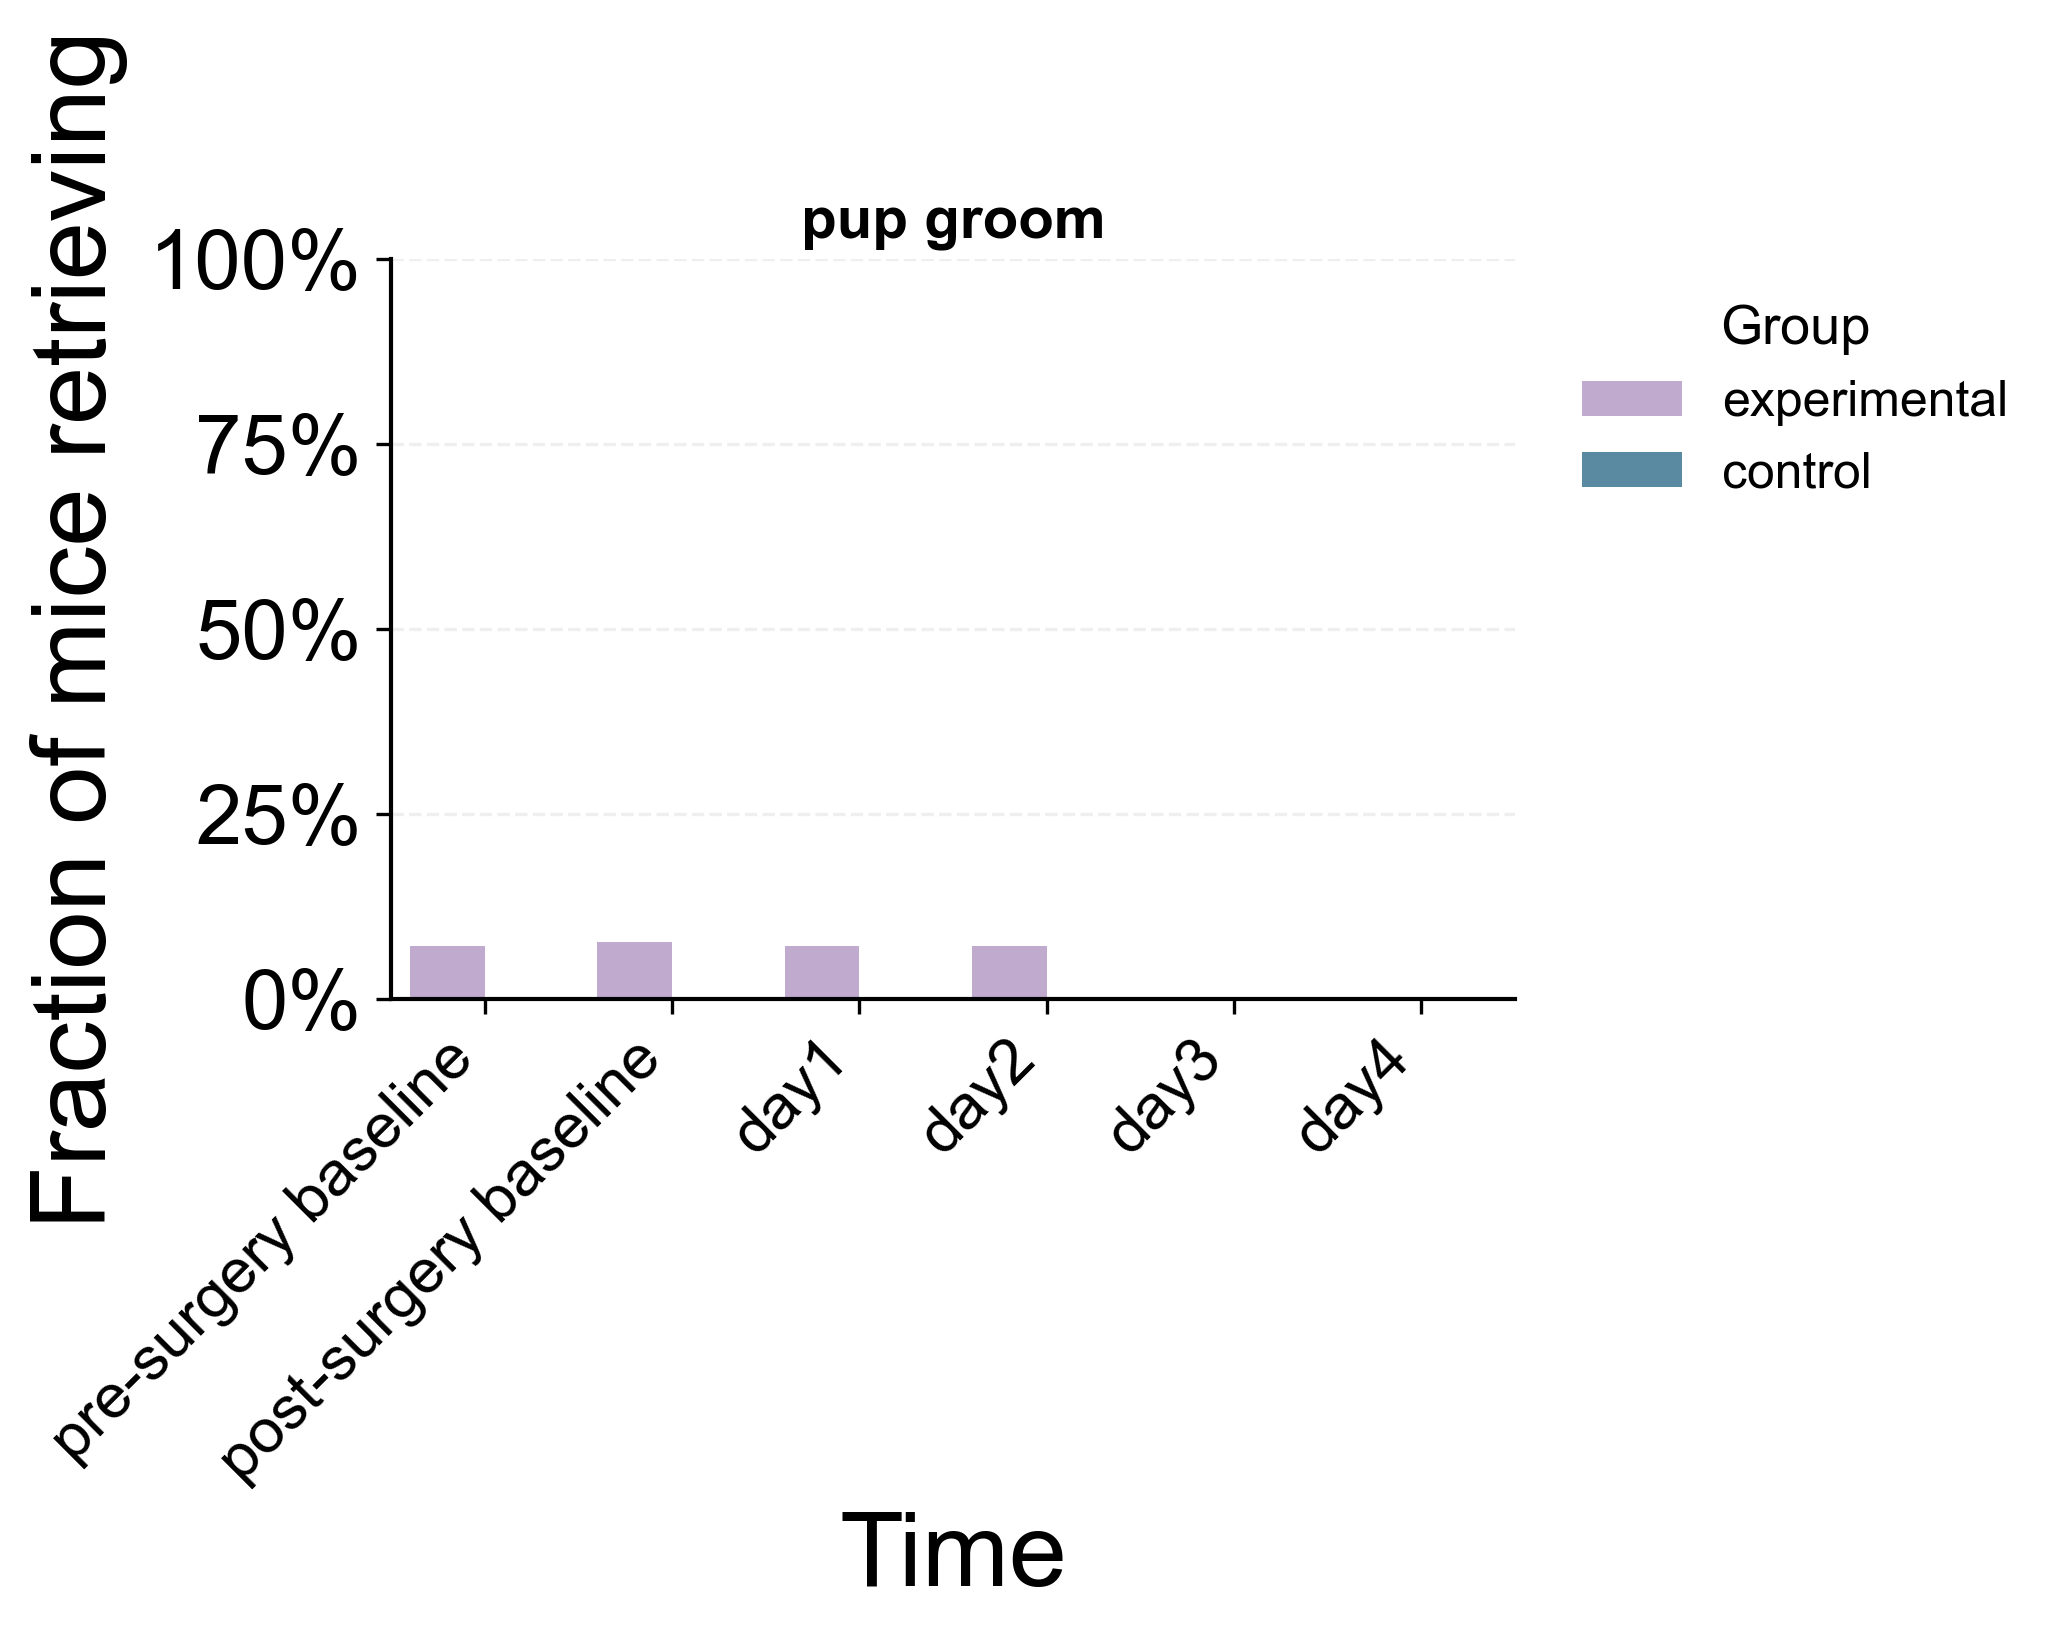

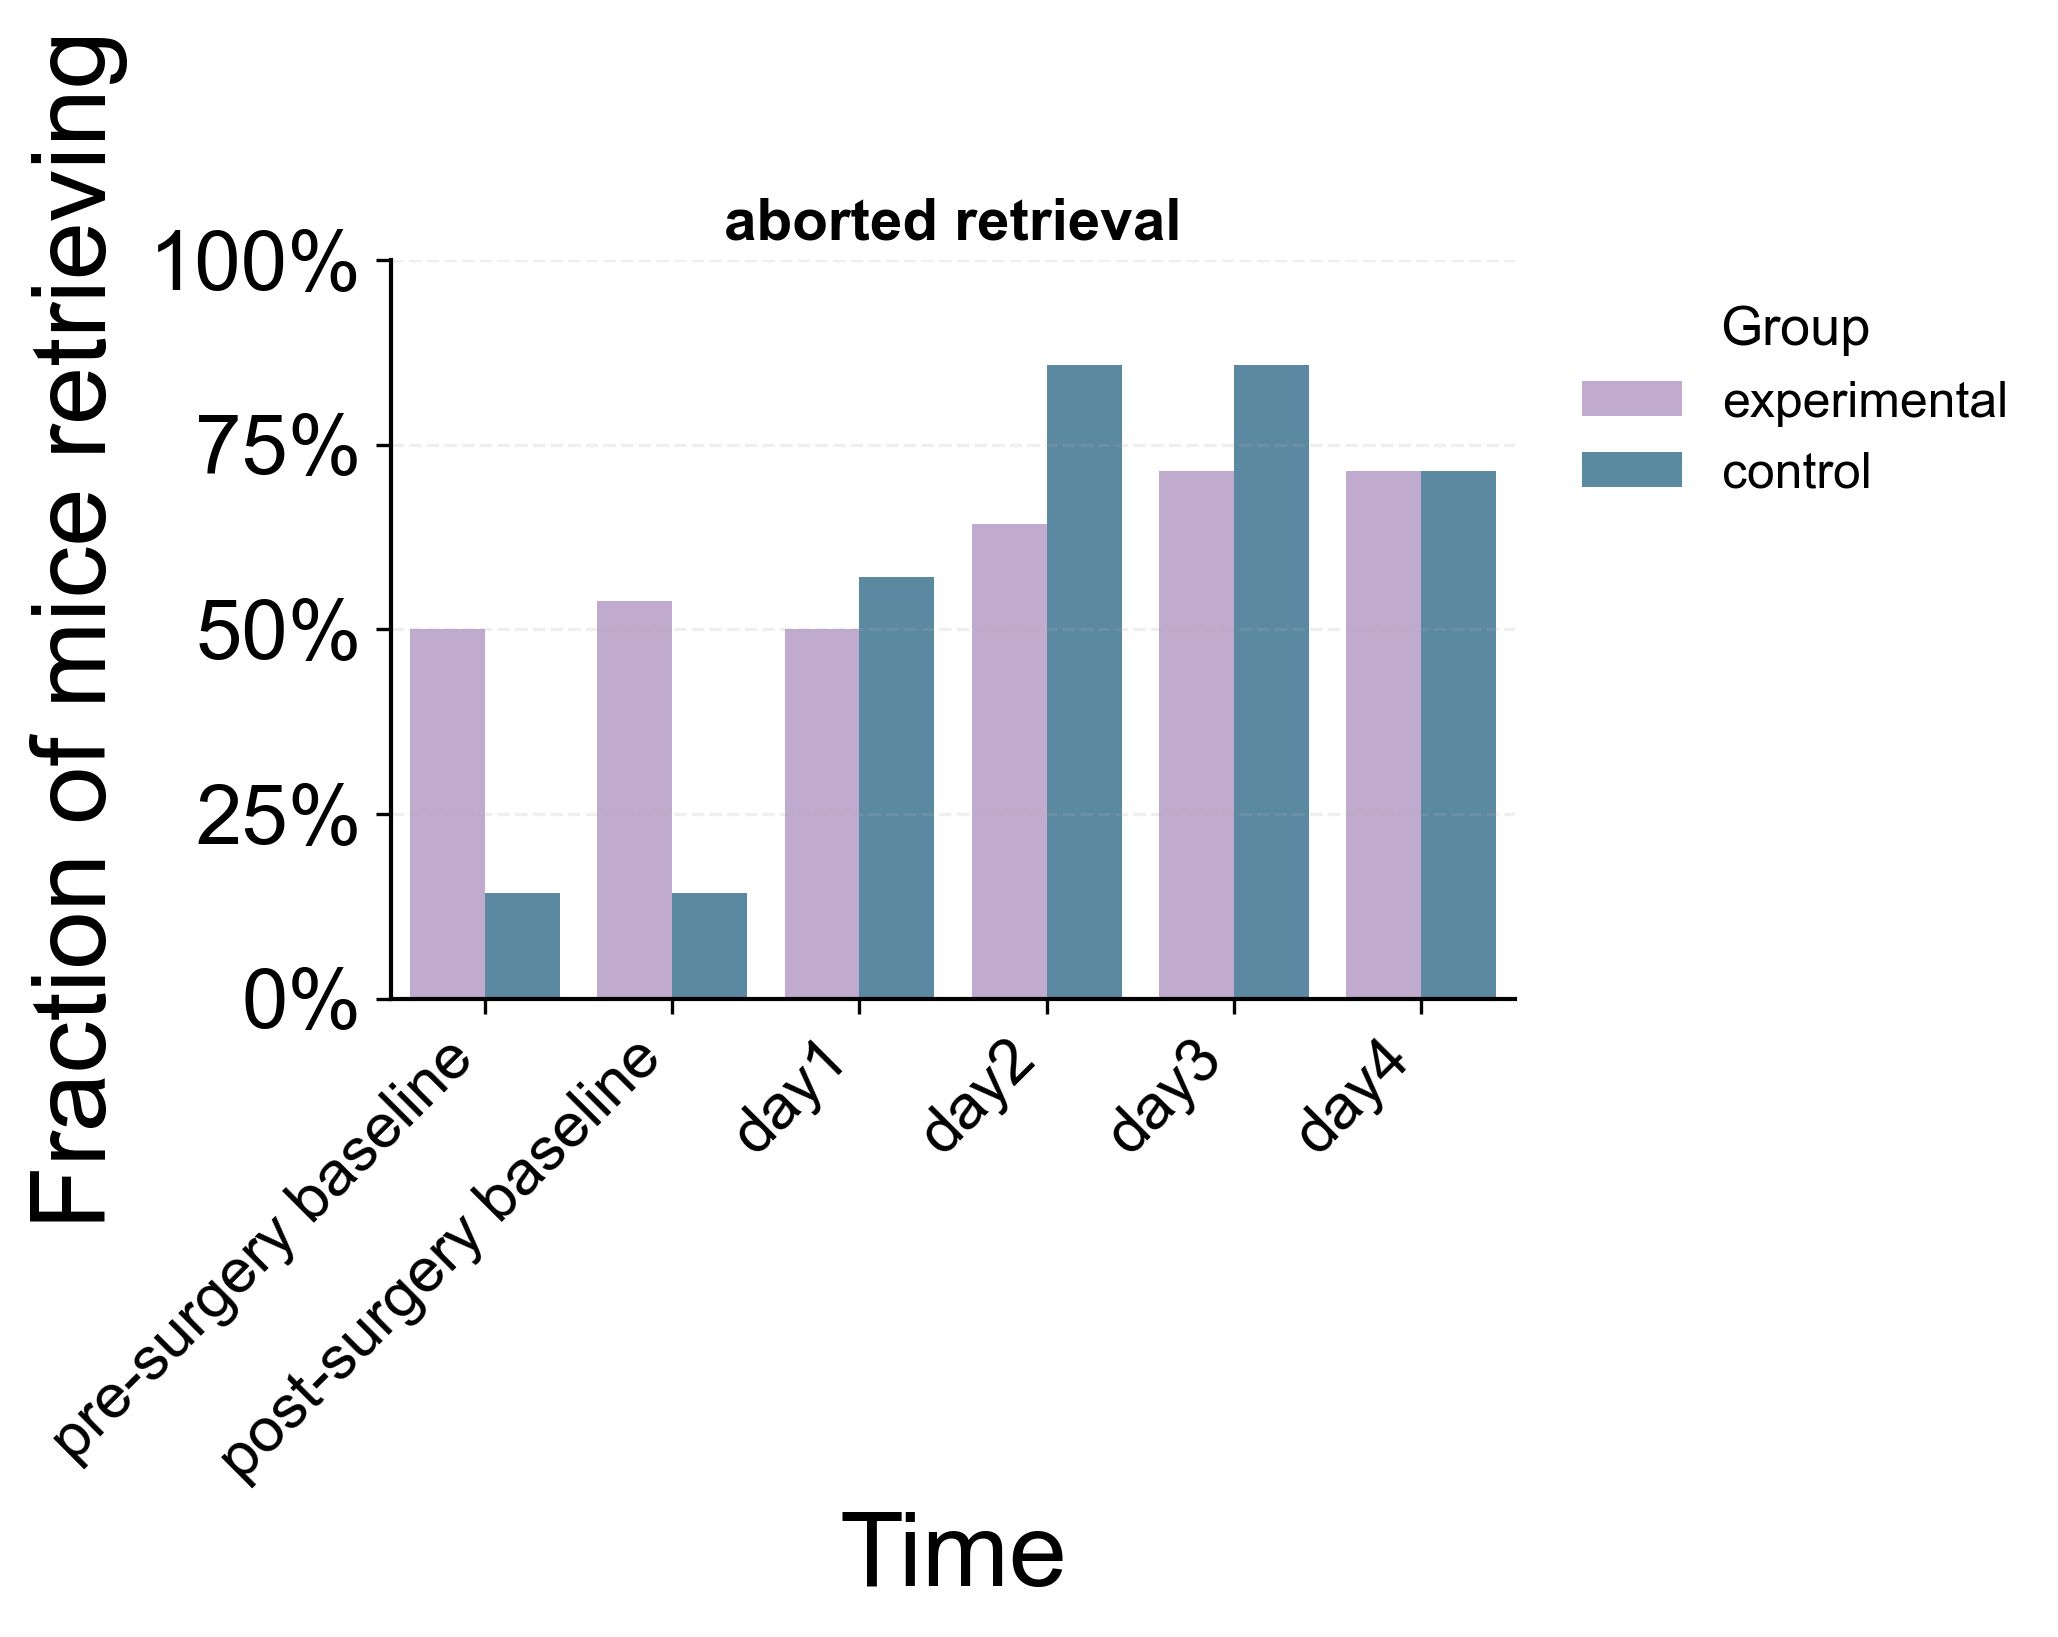

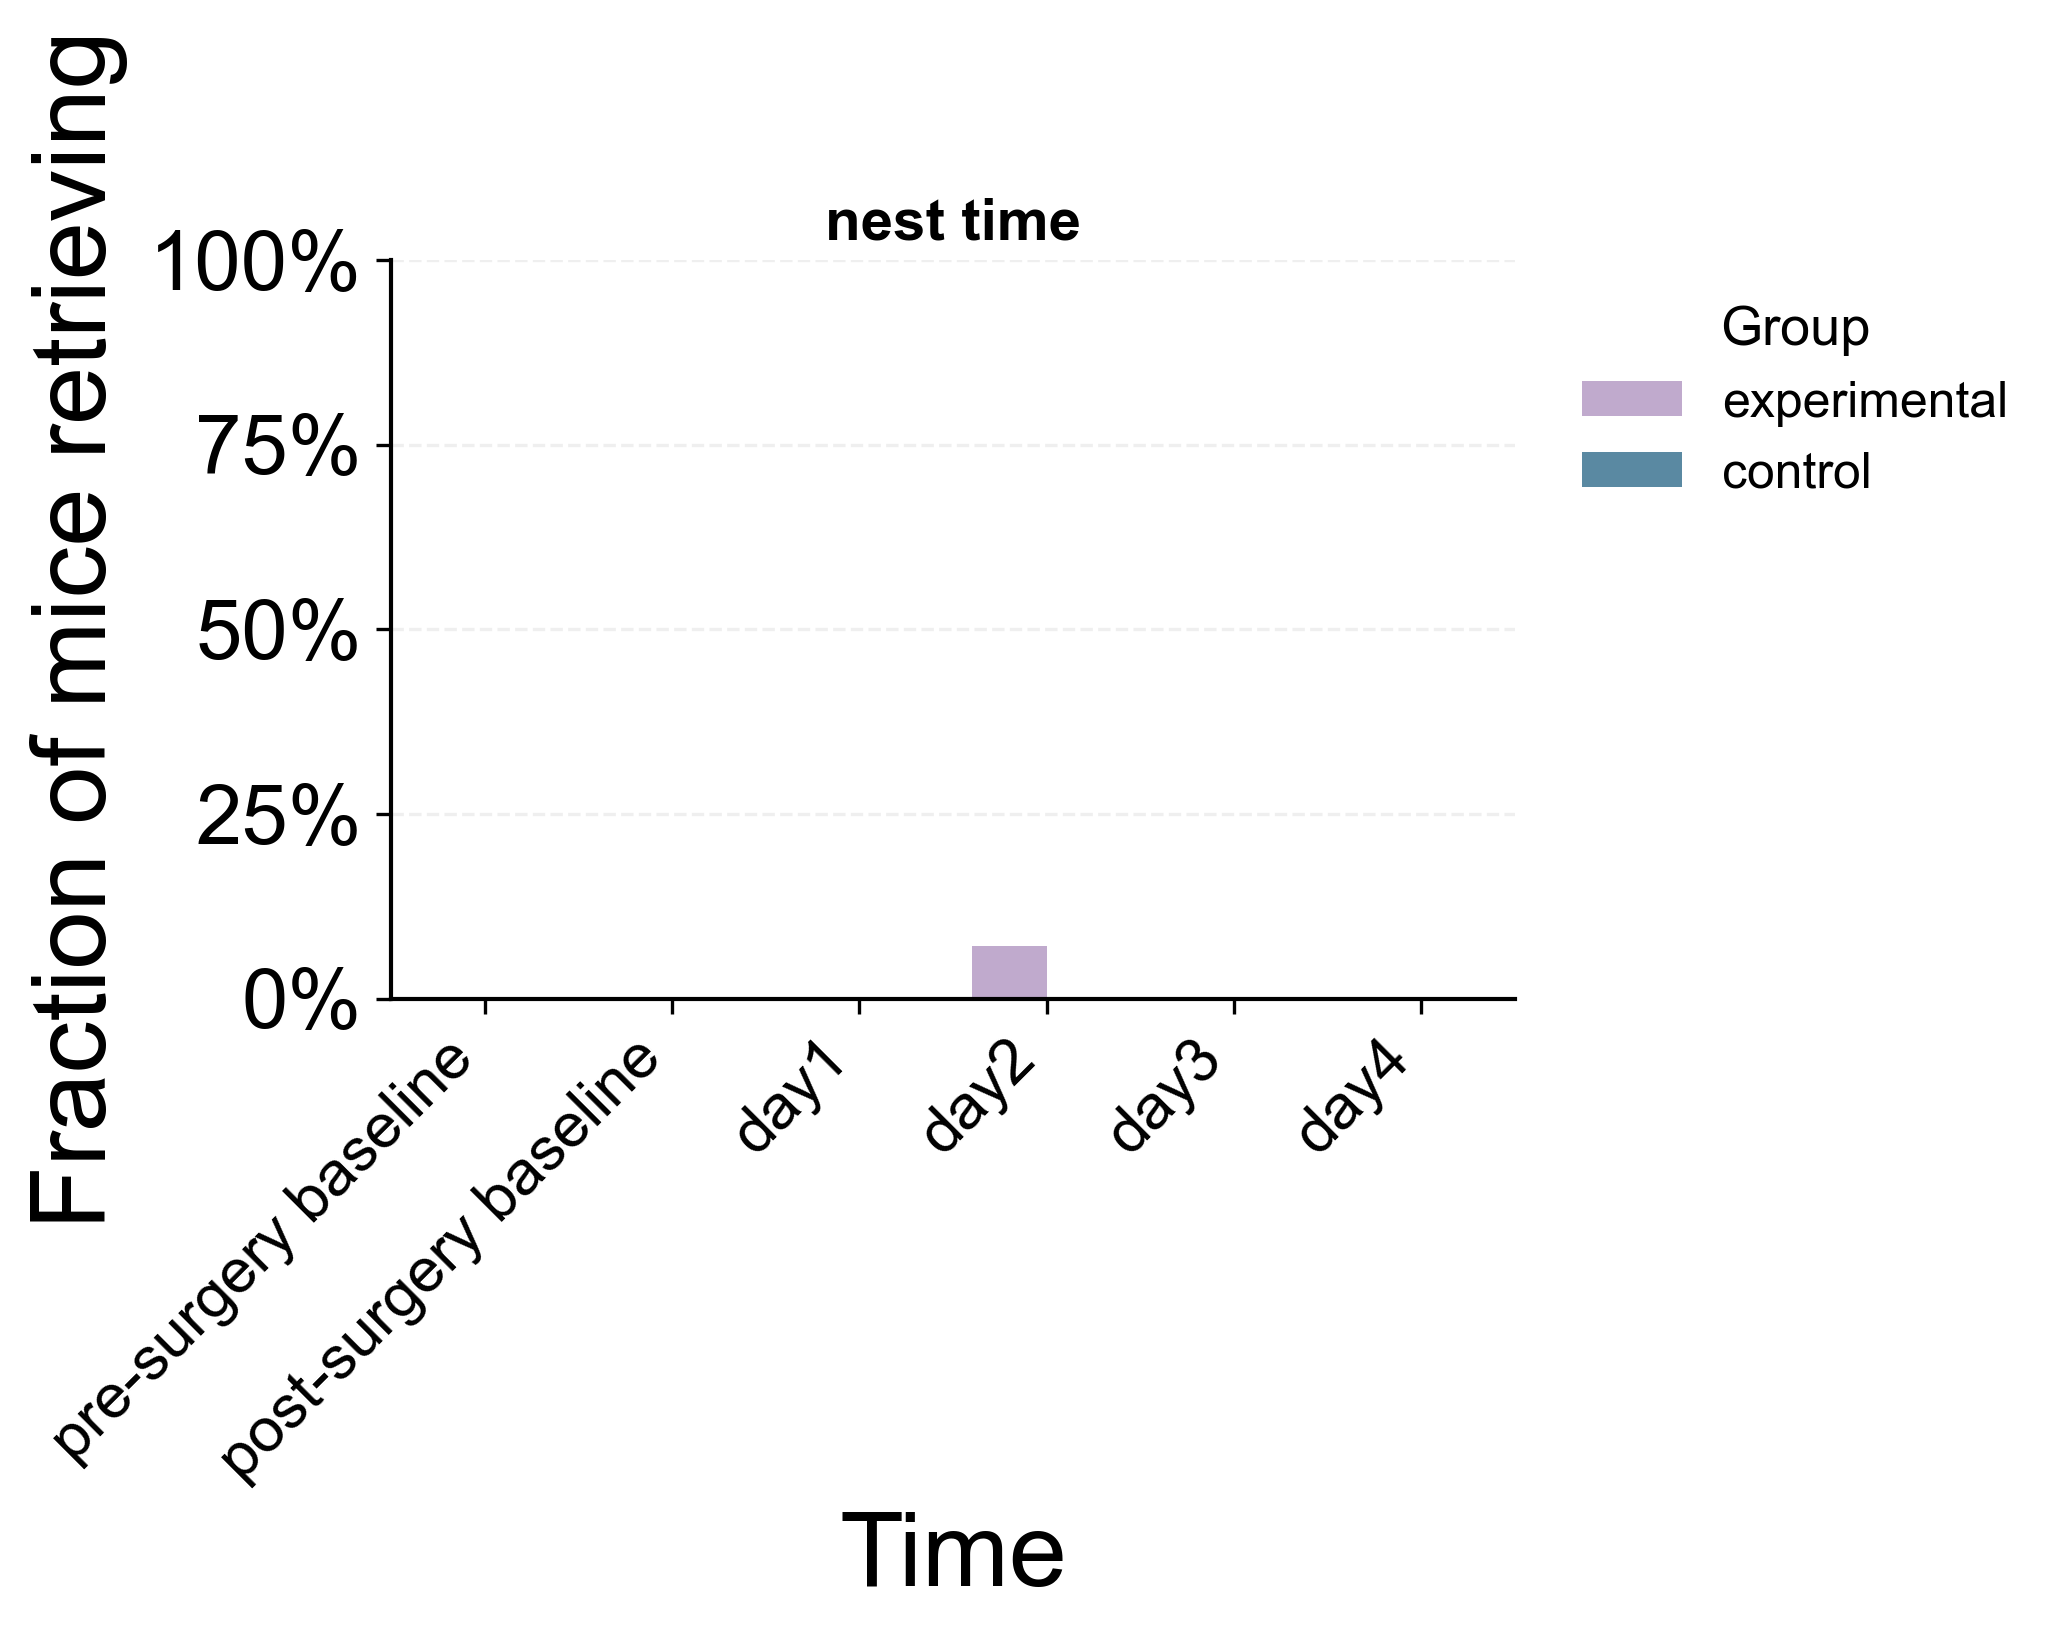

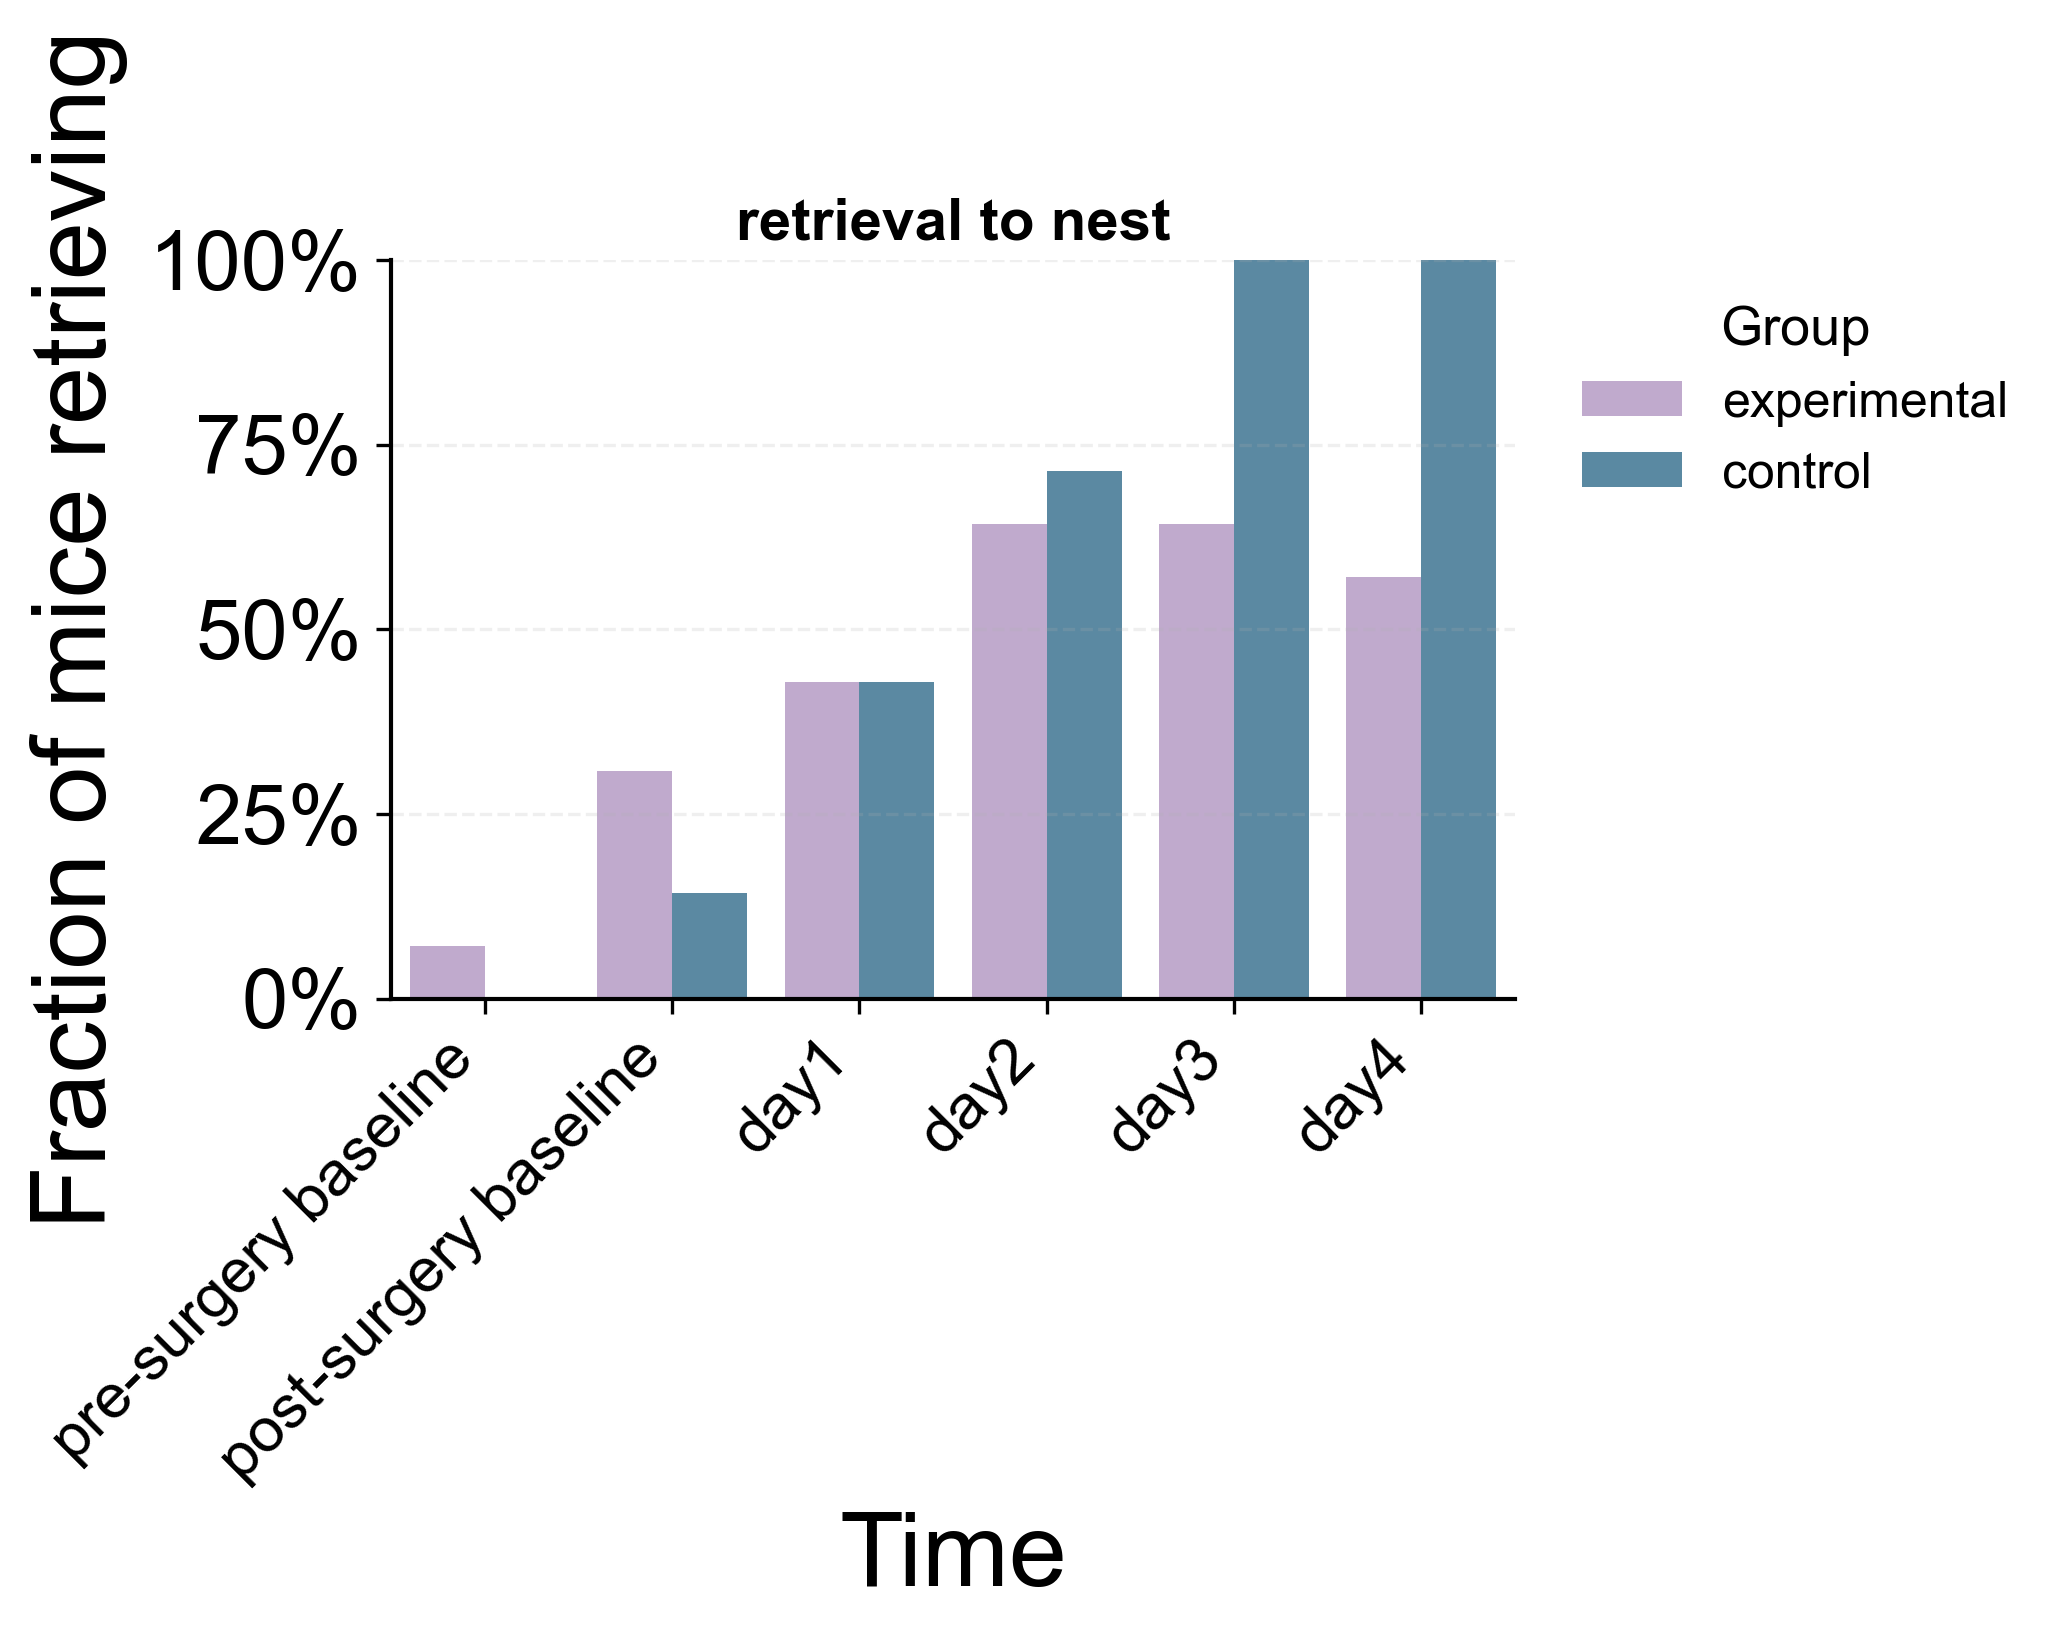

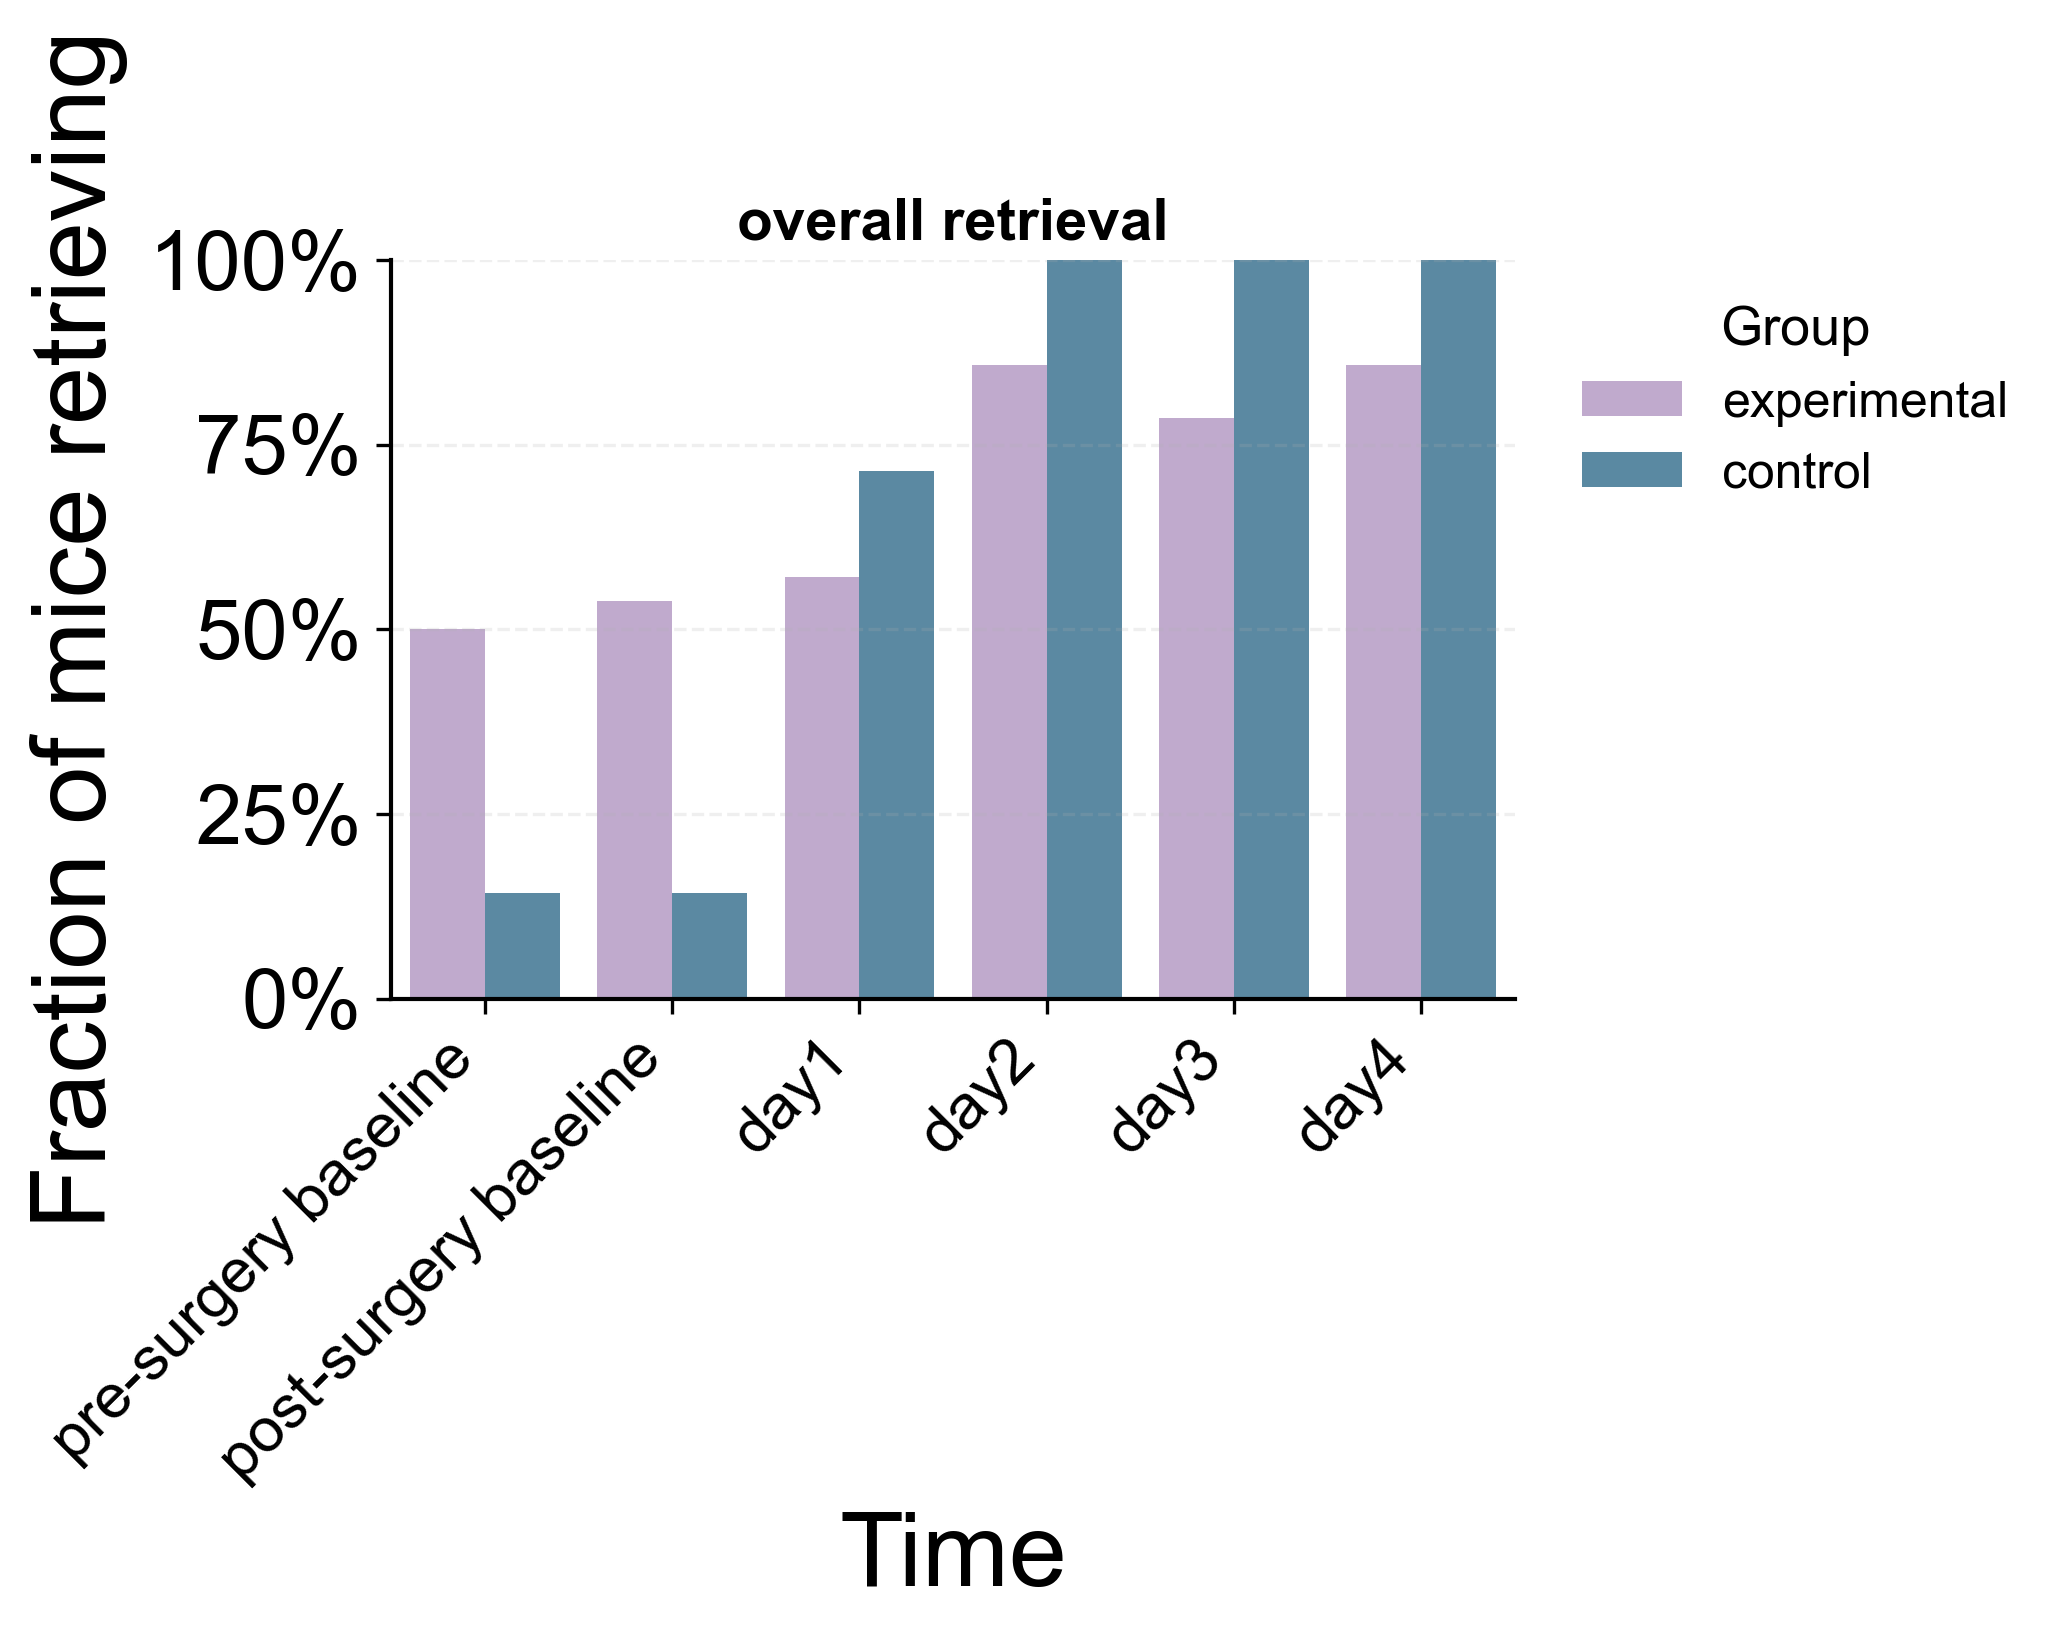

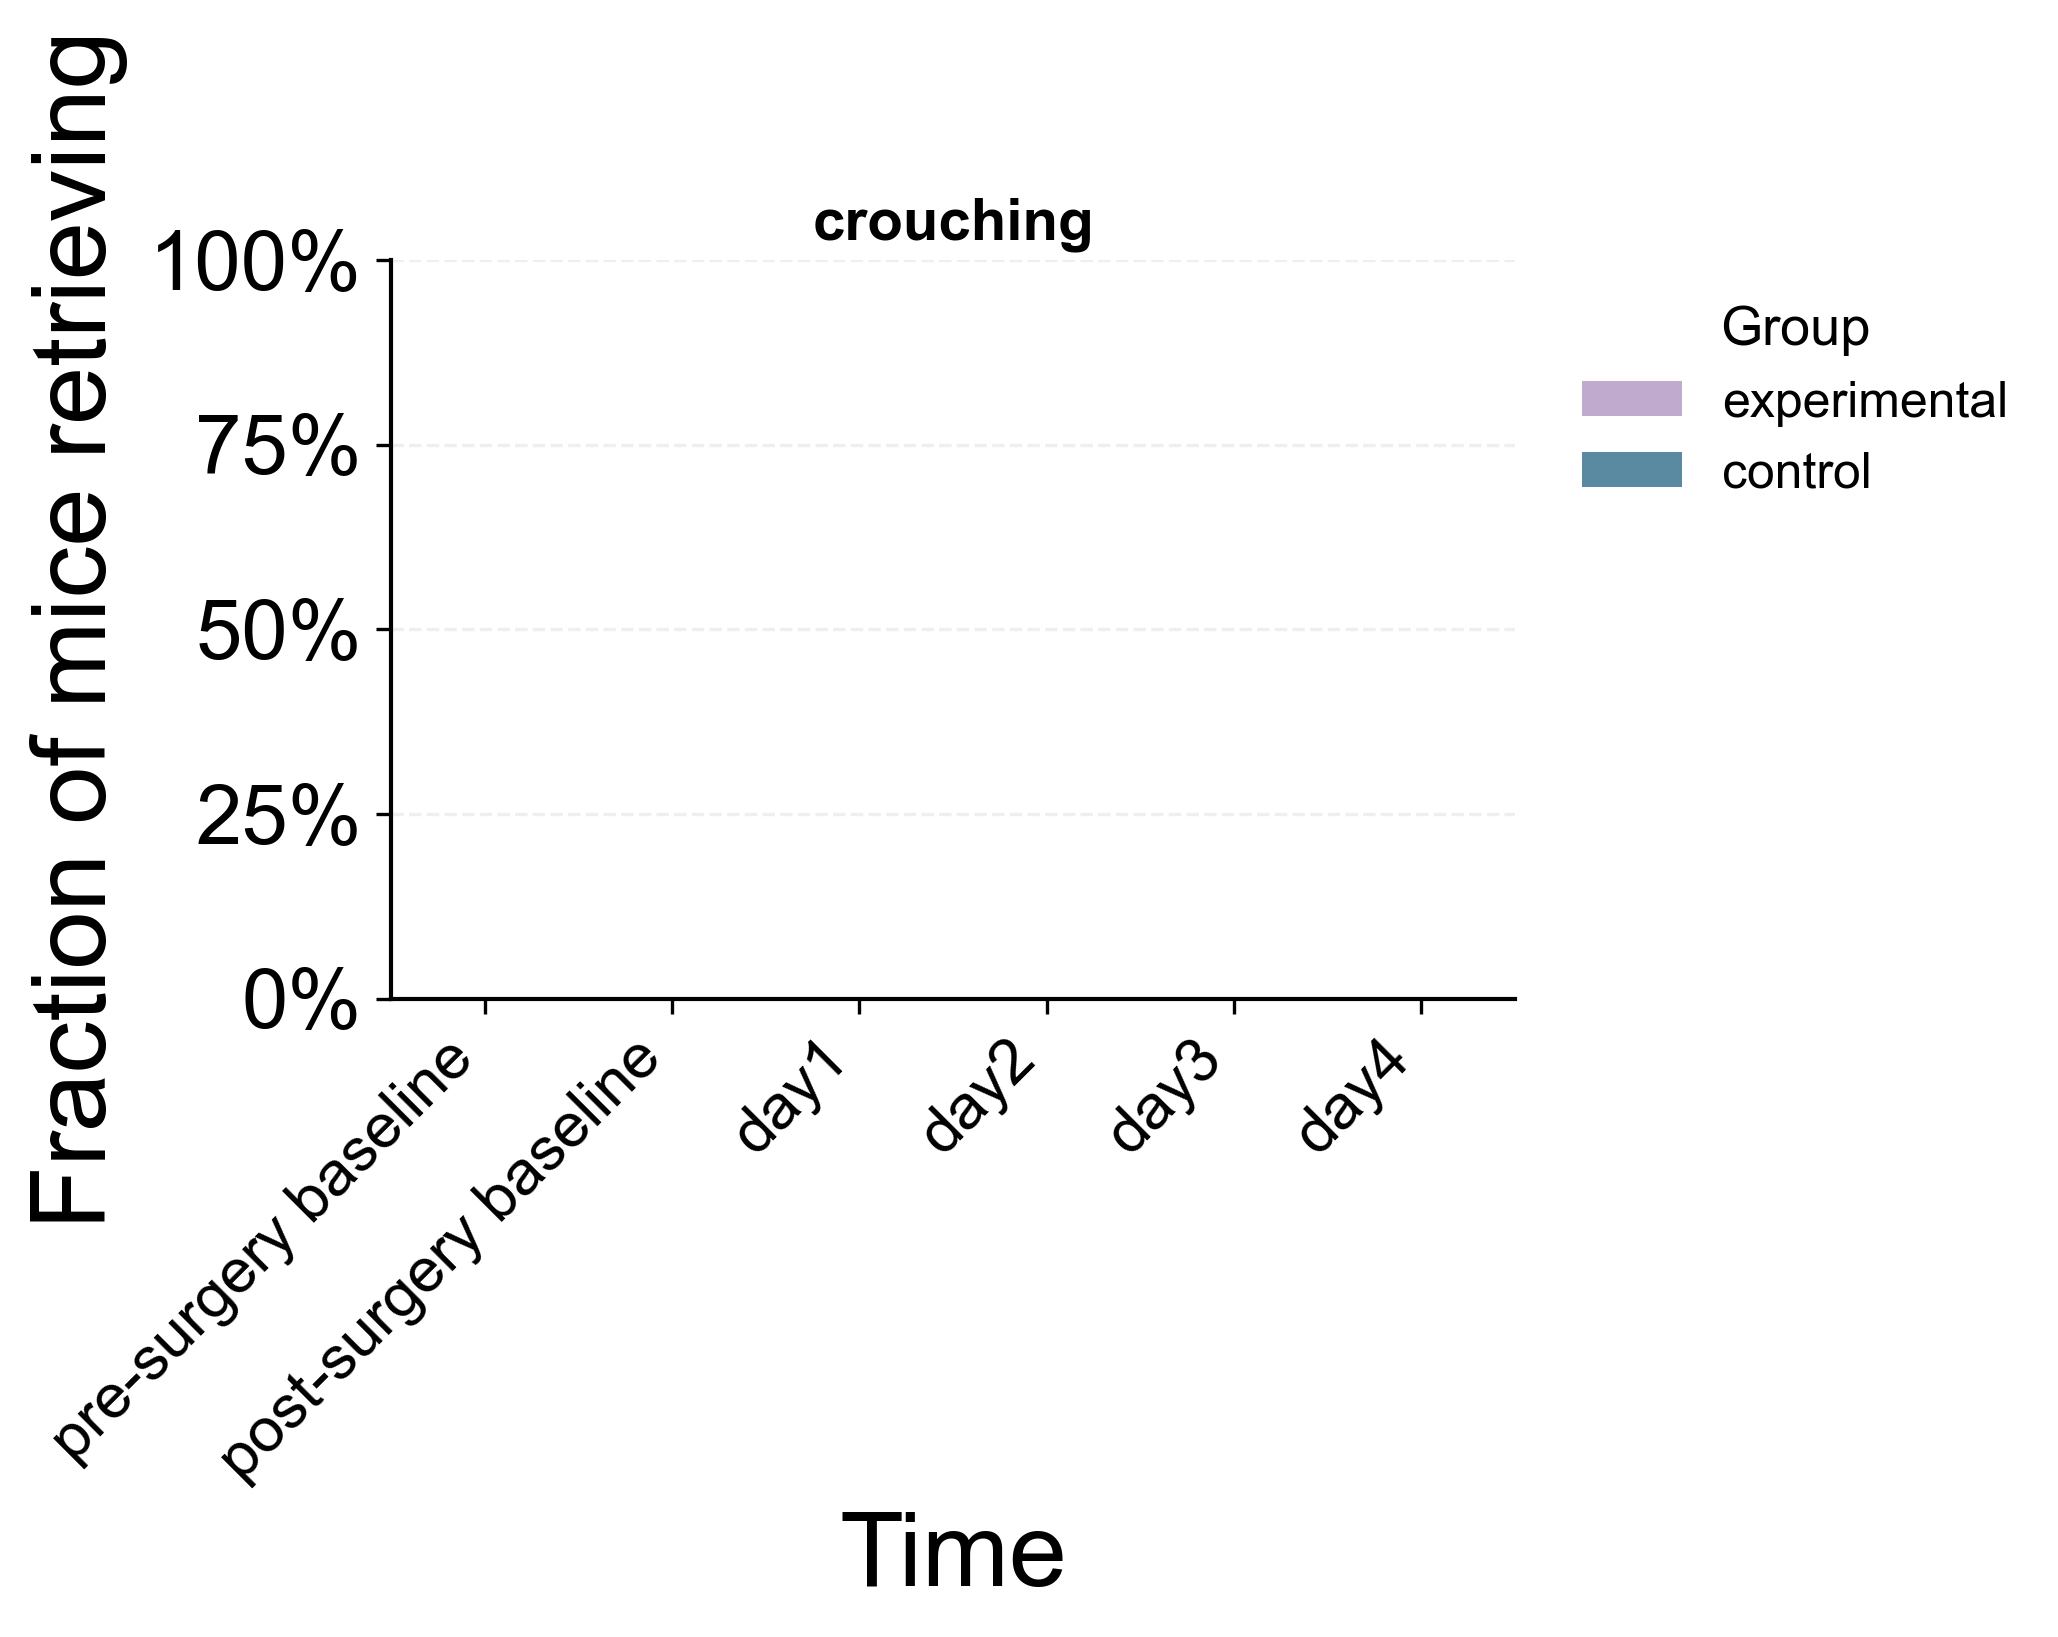

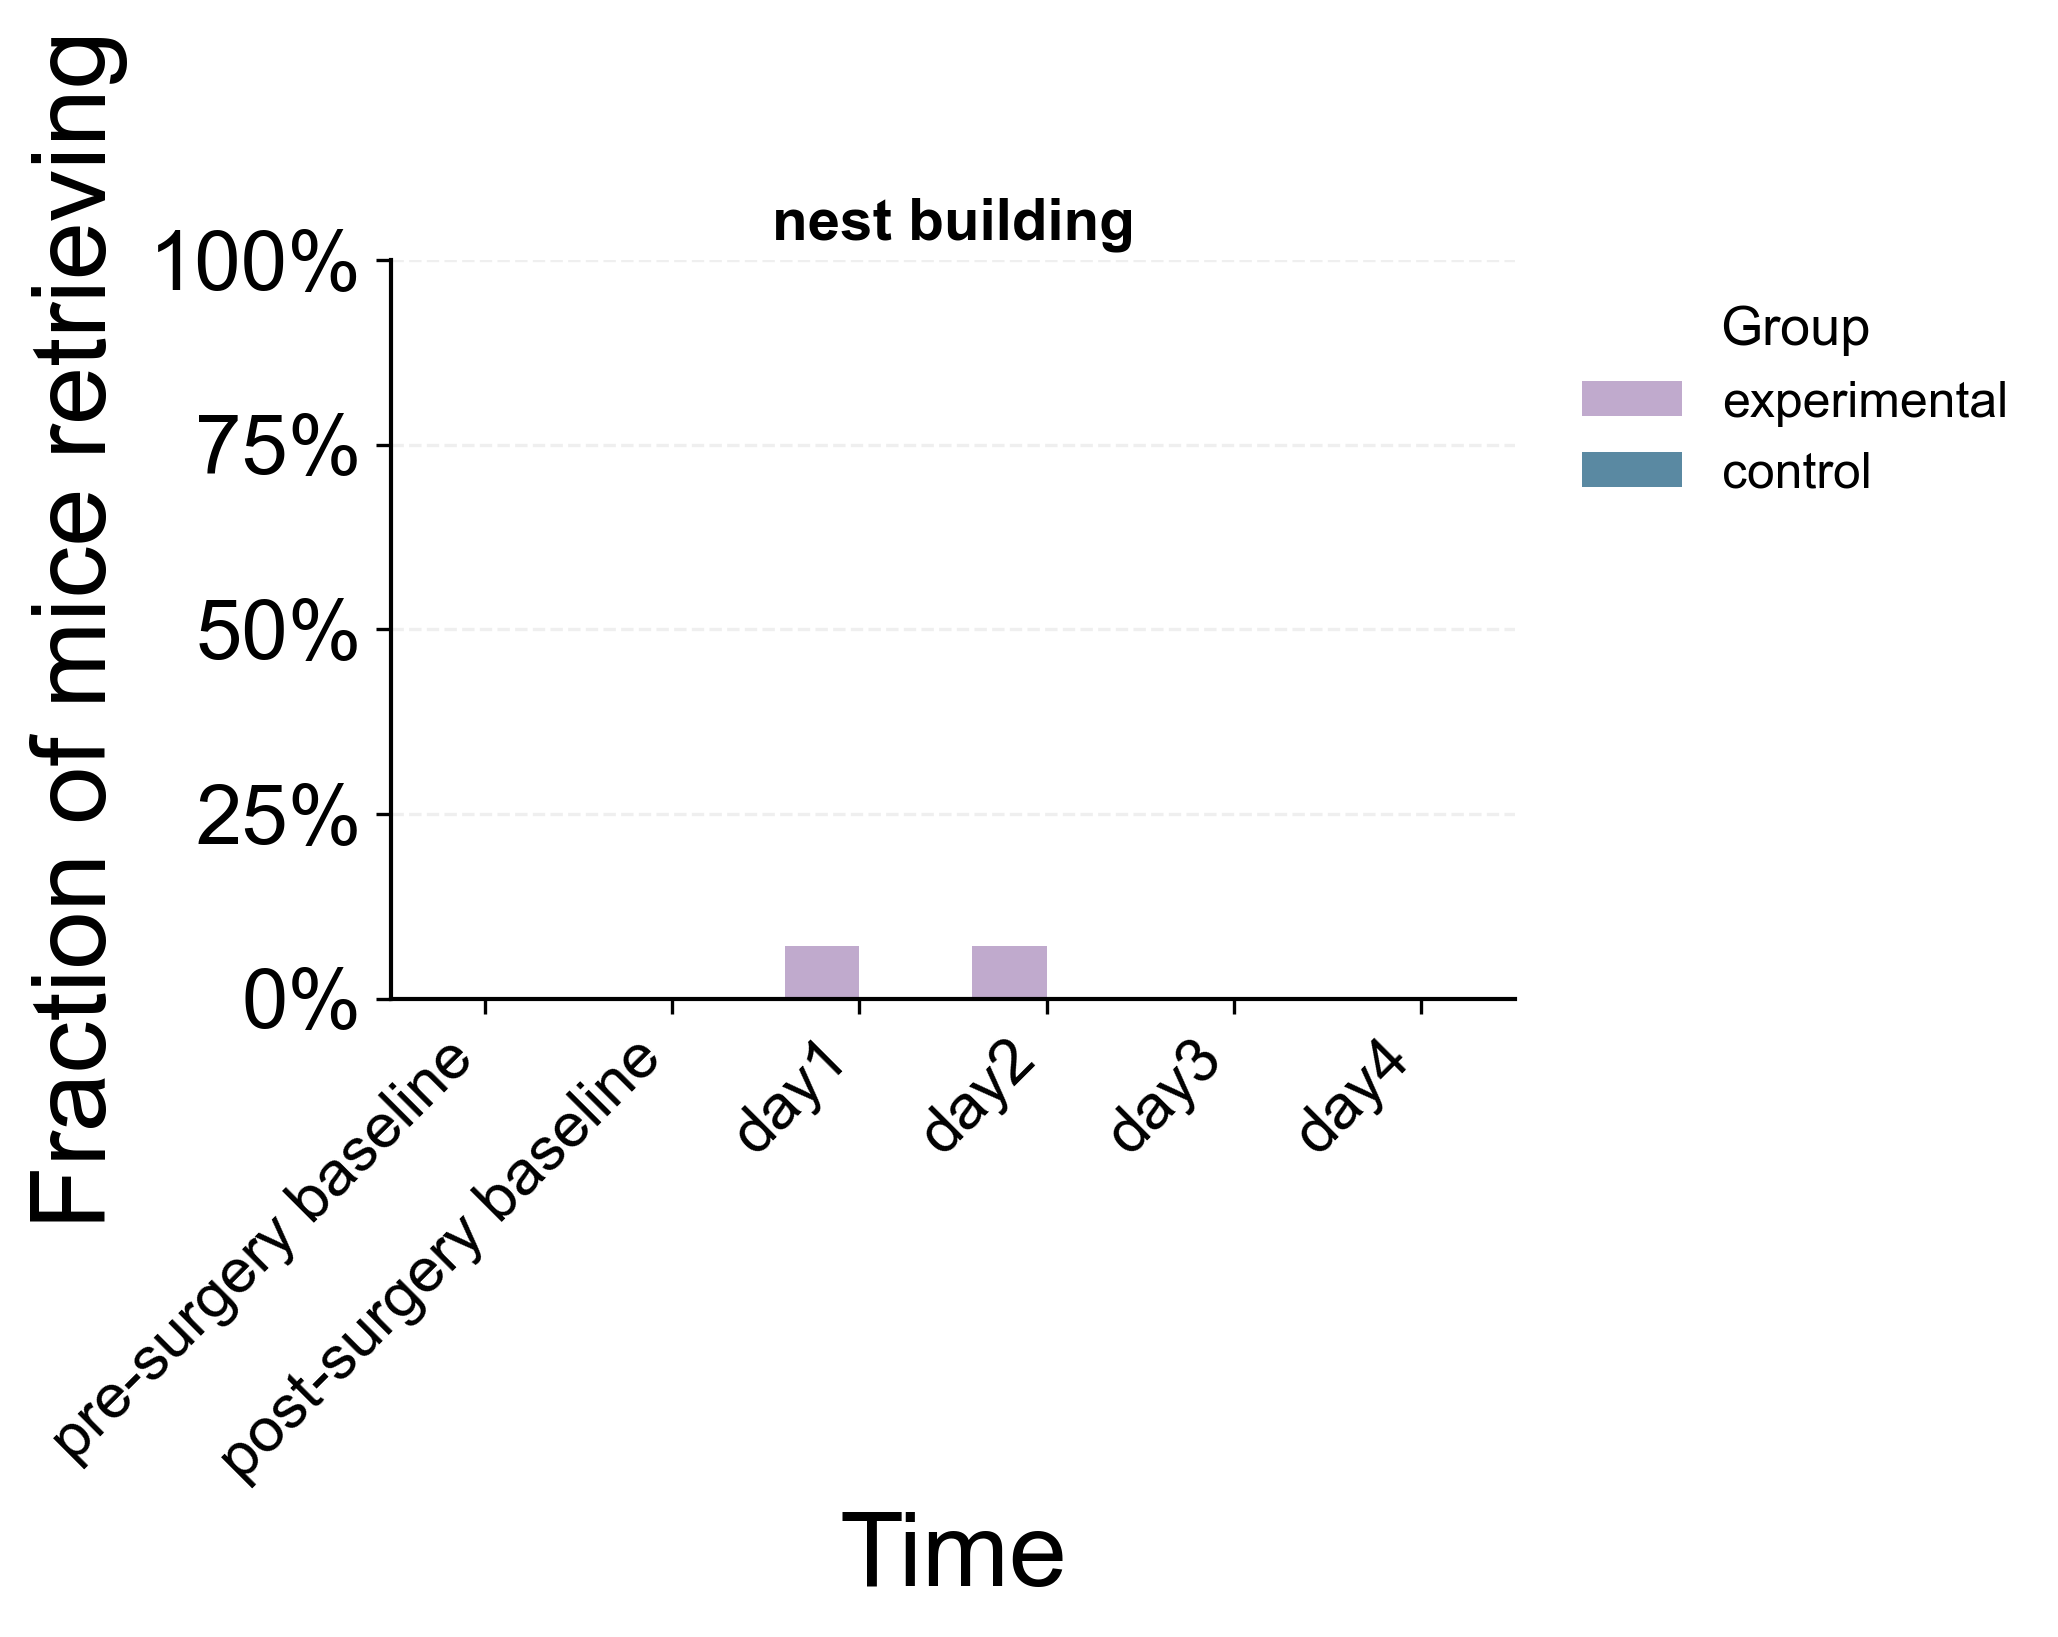

In [12]:
# Set publication-ready style parameters
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,  # Reduced font size for compact plots
    'axes.linewidth': 1,  # Thinner axes lines
    'axes.labelsize': 25,  # Smaller label size
    'axes.titlesize': 14,  # Smaller title size
    'xtick.labelsize': 15,  # Adjusted for longer labels
    'ytick.labelsize': 20,  # Smaller tick labels
    'figure.dpi': 300
})

for behaviour in percentages.behaviour.unique():
    perc_df = percentages[percentages.behaviour == behaviour]
    
    # Make a copy to avoid SettingWithCopyWarning
    perc_df = perc_df.copy()
    
    # Rename time points for clarity
    perc_df['time'] = perc_df['time'].replace({
        'baselinepre': 'pre-surgery baseline',
        'baselinepost': 'post-surgery baseline'
    })
    
    # Create figure with compact size
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Add a subtle grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    
    # Define custom palette for groups using xkcd colors
    group_palette = {
        "experimental": "#a87dc2",  # wisteria from xkcd
        "control": "#045c8c"        # muted blue from xkcd
    }
    
    # Create barplot with custom styling
    bar = sns.barplot(x="time", y="percentage", hue="group", data=perc_df,
                     palette=group_palette,
                     alpha=0.7,
                     linewidth=0.8)
    
    # Set y-axis limits and tick marks (0 to 1 for percentages)
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    # Adjust labels for compact size
    plt.ylabel('Fraction of mice retrieving', labelpad=5)
    plt.xlabel('Time', labelpad=5)  # Empty xlabel
    
    # Add title with minimal spacing
    plt.title(behaviour, pad=5, fontweight='bold')
    
    # Rotate x-tick labels for better readability with long labels
    plt.xticks(rotation=45, ha='right')
    
    # Customize legend
    handles, labels = ax.get_legend_handles_labels()
    # Position legend outside plot area
    ax.legend(handles, labels, title="Group", loc='upper left', bbox_to_anchor=(1.02, 1), 
              frameon=False, fontsize=12, title_fontsize=13)
    
    # Remove unnecessary spines
    sns.despine()
    
    # Adjust figure size to accommodate legend
    fig.tight_layout()
    # Add extra space for the legend
    plt.subplots_adjust(right=0.85)
    
    # Save figures in publication-ready formats
    plt.savefig(f'plots_chem_bnst/{behaviour}_percentage.png', dpi=500, bbox_inches='tight')
    
    plt.show()